# Phase space reconstruction from ECG recordings

### Ana Daniela del Río Pulido and Erin C. McKiernan

### Facultad de Ciencias, UNAM

In this practical, students will graph and analyze electrocardiogram (ECG) data using Python 3. Raw recordings for this practical can be collected by students, or they can work with existing recordings from our repository. Students will also learn to use the time delay method for reconstructing phase space from a time series.

In the repository there is information of at least 12 people from 20 to 30 years of age. None of them was diagnosed with a cardiac arrythmia, except one. These recordings come in pairs, one is the subject in a resting state and the other recording is the subject after performing exercise. It is important to note that the amount of exercise done by these subjects was not a variable we controlled, it was simply running up and down the stairs. In a future work, we are looking forward into controlling this variable.

## Human electrocardiogram
The human electrocardiogram (ecg) is a physiological signal that is measured by placing electrodes that record the heart's voltage changes. Each part of the obtained signal corresponds to a particular action of the heart [Boron and Boulpaep, 2012] [BackyardBrains, 2017] [Kantz and Schreiber, 2004, pg. 344], this can be seen in the following figure. One period of the electrical signal of the heart is called the PQRST wave complex.
<img src="ecg.png" width ="500" height ="200" > 

# Setting up the notebook

We begin by setting up the Jupyter notebook and importing the Python modules needed for plotting figures, create animations, etc. We include commands to view plots in the Jupyter notebook, and to create figures with good resolution and large labels. These commands can be customized to produce figures with other specifications.

In [1]:
# Imports python libraries
import numpy as np
import random as rd
import wave
import sys
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
sys.path.insert(1, r'./../functions') # add to pythonpath

#For creating animations and plotting in 3D
from matplotlib import rc
import matplotlib.animation as animation
from JSAnimation import IPython_display
from mpl_toolkits.mplot3d import Axes3D


# commands to create high-resolution figures with large labels
%config InlineBackend.figure_formats = {'png', 'retina'} 
plt.rcParams['axes.labelsize'] = 16 # fontsize for figure labels
plt.rcParams['axes.titlesize'] = 18 # fontsize for figure titles
plt.rcParams['font.size'] = 14 # fontsize for figure numbers
plt.rcParams['lines.linewidth'] = 1.4 # line width for plotting

## Extracting and graphing the data

ECG recordings were obtained using the Backyard Brains Heart and Brain Spiker Box. The recordings are saved as audio files in .wav format. The first thing we have to do is open the .wav files and extract the data. We can extract the number of recording channels, sampling rate, etc.

In [2]:
#Function that extracts the number of recording channels, sampling rate, time and signal
#variable is the path and filename of the .wav file
def ecg(variable):
    record = wave.open(variable, 'r') # load the data

    # Get the number of channels, sample rate, etc.
    numChannels = record.getnchannels() #number of channels
    numFrames = record.getnframes() #number of frames
    sampleRate = record.getframerate() #sampling rate
    sampleWidth = record.getsampwidth()
    
    # Get wave data
    dstr = record.readframes(numFrames * numChannels)
    waveData = np.frombuffer(dstr, np.int16)

    # Get time window
    timeEMG = np.linspace(0, len(waveData)/sampleRate, num=len(waveData))

    return timeEMG, waveData

Now, let's plot the raw ECG signal.

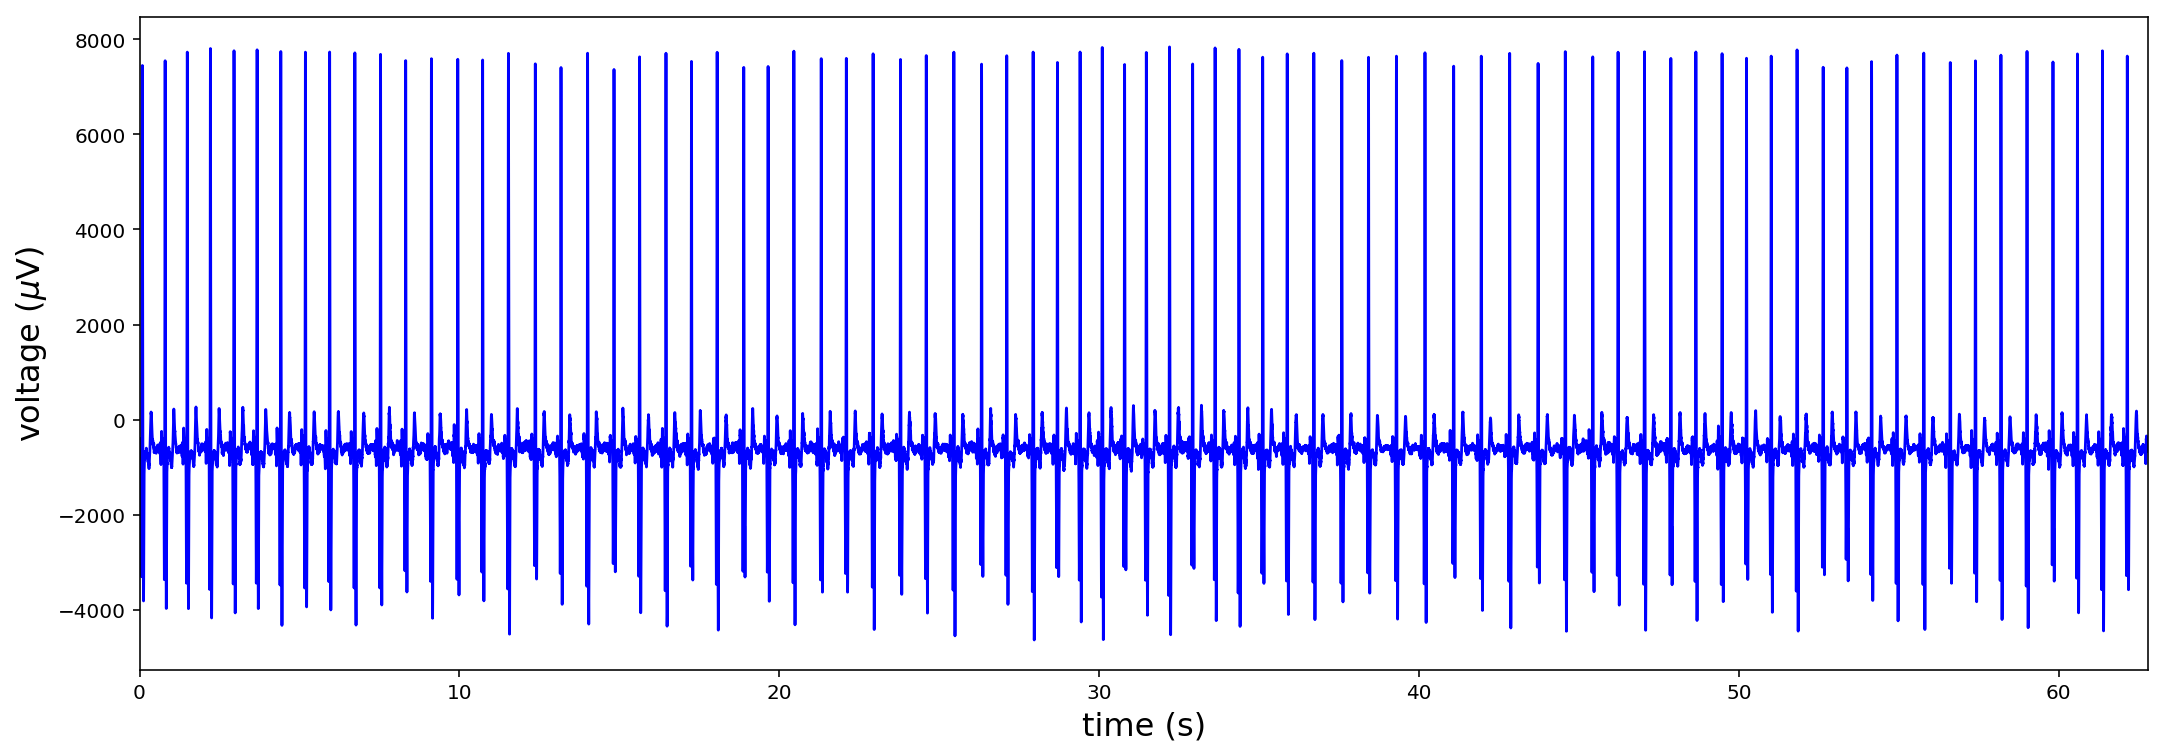

In [3]:
#Obtaining data
timeEMG, waveData = ecg("S1_rest.wav")

# Plotting EMG signal
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.plot(timeEMG,waveData, 'b')
plt.xlim(0,max(timeEMG))
plt.show()

Find out about how many points make points make up one cycle.

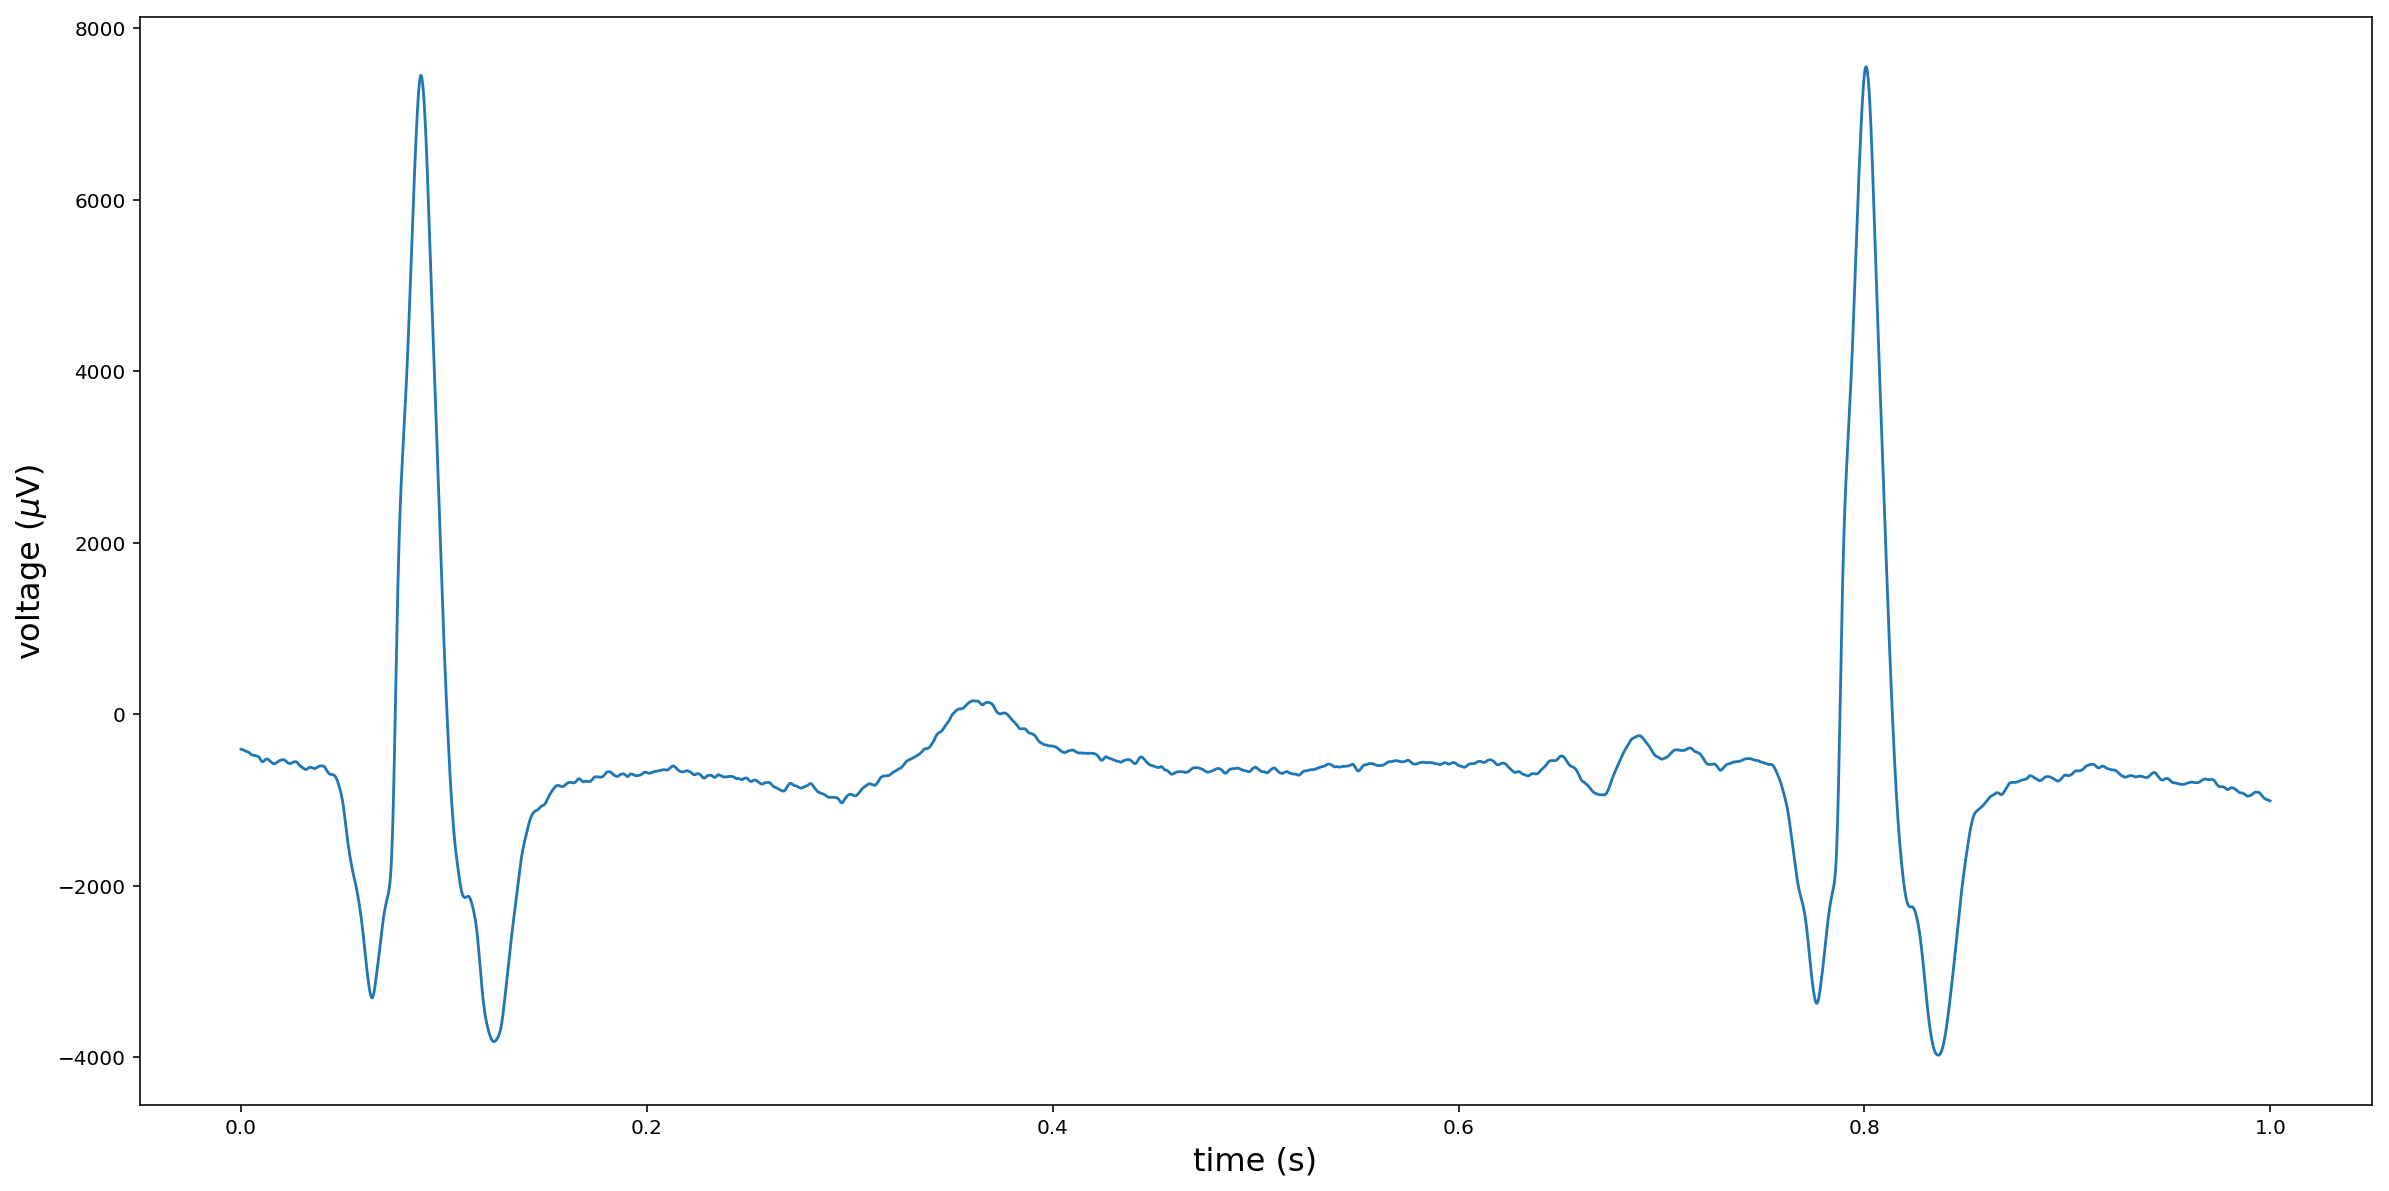

In [4]:
n = 10000
plt.figure(figsize=(20,10))
plt.plot(timeEMG[0:n], waveData[0:n])
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.show()

We know that the average heart rate is 60 to 100 cycles per minute. This is around 1 cycle per second.
Considering that the heart rate is 60 cycles per minute (1 cycle per second), the number of data points that make up one cycle is 10 000 data points.

# Time series

A **time series** is a sequence of measurements of an observable or scalar quantity that changes in time and which depends on the current state of the system. We
can think about this time series ($s_n$) as a function of the state ($x$) which depends on the n-th measurement at a certain time interval ($∆t$) [Kantz and Schreiber, 2004, pg. 35].

\begin{equation}
    s_n = s(x(n∆t)) + η_n
\end{equation}
    
Where:

• $s_n$ : observable or scalar quantity

• $η_n$ : noise or random fluctuations

# What do time series and electrocardiogram have in common?

Well, the ecg is precisely a time series of the heart's electric signals! It is very important to study the heart because the leading cause of death globall are cardiovascular diseases. 3 out of 10 deaths are because of heart disease [WHO, 2019]. 
If simpler techniques for studying the heart are developed, more people could be saved from heart failure. With this in mind, we will start uncovering the intricacies of the heart's dynamics.

# A little bit of theory about dynamical systems

Dynamics is the subject that deals with change, *i.e.* with systems that evolve in time. A system could do anything, like: settling to equilibrium, keep repeating cycles or do other complicated patterns [Strogatz, 1994, pg. 2]. For example, a system could be anything as complicated as the human being, a bacteria, global market or even a pendullum (we will come back to this last example later).

<img src="pendullum.png" width ="200" height ="100" > 
Image taken from: https://i.imgur.com/b2eX4w6.png (Consulted on March 21, 2020)

The **phase space** is a space in which all possible states of a system are represented. *I.e.* each point in phase space represents a possible state of the system. One can think of phase space as completely filled with trajectories. Imagine that every possible state of the system is an initial condition [Strogatz, 1994, pg. 7]. Depending on the system's dynamics is how the system will evolve in time. For example, thing of a pendullum with no friction. A possible state of the system is not moving at all (represented by a point in the following image). Another state of the system is oscillating in a small angle (small oscillations). Another one is completing full turns (represented by the red line). It is important to understand the concept of phase space because the rest of the notebook is based on this concept. If it is not clear, make a quick Google search about this concept.

<img src="phase_space_pendullum.png" width ="400" height ="150" > 
Image taken from: https://www.researchgate.net/profile/Rowena_Ball/publication/2148876/figure/fig5/AS:668675875041284@1536436160306/The-phase-space-of-the-simple-pendulum.png (Consulted on March 23, 2020)


The phase space does not necessarily have to be a plane or three-dimensional. Its dimension is the number of variables needed to characterize the state of the system [Strogatz, 1994, pg. 9].

Sometimes, a system is on a state that if it remains unperturbed, it will stay forever in this state. This is called a fixed point and there are two kinds: attractos and repellers. An **attractor** is a point in the state space where given an initial condition, the system will eventually get to the fixed point. In the pendullum example, the attractor is when it is hanging in a 90 degree angle with respect to the floor. Imagine the pendullum started at a different angle and was not perturbed by any outside factor, then it would oscillate forever in that cycle.


The attractor of a system does not necesarrily have to be a single point or cycle. Sometimes it takes different and beautiful forms. Have you ever seen the movie: **The butterfly effect**? It is based on the following image. It is the attractor of a system called the Lorenz system. As you can see, it looks nothing like a point. Observe how the attractor of a system can take any shape.
<img src="Lorentz_attractor.png" width ="200" height ="100" > 
Image taken from: https://upload.wikimedia.org/wikipedia/commons/7/71/Lorenz_system_r28_s10_b2-6666.png (Consulted on March 21, 2020)

In general, the attractor of a system is N-dimensional. This can lead to visualization problems because of human's perceptual limitations. Througout the notebook, we are going to be restricted to 2 or 3 dimensional slices of the phase space, that is were the attractors are. 

## Phase space reconstruction

How can you reconstruct the phase space of a system if you only have a time series of one of the system's variables?

Very simple! Other people have thought about that and we can use what they have discovered. There is a very famous article in Dynamical Systems called Embedology from Sauer et al. in 1991. They assure that given the time series of only one observed quantity, it is possible to reconstruct the attractor (which lies in phase space) [Sauer et al., 1991,
pp. 580]. 

There are various methods for reconstructing the attractor, a now famous one is the principal-component analysis [Broomhead and King, 1986] [Savi, 2005, pg.
635]. Nevertheless, we will focus on the **method of delay**, also called Taken's theorem [Takens, 1981]. The theorem is the following:

Let $A$ be an attractor that lies in an N-dimensional compact manifold $M \subset \mathbb{R}^n$. Define a reconstruction function $F:M\rightarrow \mathbb{R}^{2N+1}$ as
  \begin{equation}
      F(x) := [\phi_0^{(j)}(x) \phi_\tau^{(j)}(x) ... \phi_{2N\tau}^{(j)}(x)]^T
  \end{equation}
  Where $\phi_t^{(j)}(x)$ is the $j$th component of $\phi_t(x)$, $j$ is arbitrary and $\tau > 0$ is the sampling period chosen arbitrarily.
  
  (Notice that $\phi_t(x)$ is an observable or scalar quantity. This is precisely our time series. $\phi_t^{(j)}(x)$ represents the $j$th component of this time series.)
  
  F is an embedding, *i.e.* F diffeomorphically maps M onto some compact N-dimensional manifold $M' \subset \mathbb{R}^{2N+1}$. (This is the beauty of this theorem, that this function F exists between the observable and the attractor.)
  
  So, given a sequence $\{y_k\} := \{\phi_{k\tau}^{(j)}\}_{k=1}^\kappa$ that corresponds to a uniformly time-sampled component of a trajectory that lies on an attractor A, the sequence of points

\begin{align*} 
     [y_0 y_1 ... y_{2N}]^T
    \\
     [y_1 y_2 ... y_{2N+1}]^T
     \\
     \vdots
     \\
     [y_i y_{i+1} ... y_{i+2N}]^T
     \\
     \vdots
     \\
     [y_{K-2N} y_{K-2N+1} ... y_{K}]^T
\end{align*}

  lies on a diffeomorphic copy of A [Parker and Chua, 2012, pp. 191].
  
  ($\{y_k\}$ is the reconstructed attractor we are looking for.) 
  
  In essence, this theorem states that a function exists between an observable of a system and its attractor.
  
  ### Time lag
  
  The **time lag** ($\tau$) is the difference between two data samples and it is called lag or delay time. It has no relevance in the mathematical framework, so there is no formal way of obtaining its optimal value. Nevertheless, $\tau$ is relevant in practice [Sauer, 2006] [Parker and Chua, 2012, pp. 195].
  
  • If $\tau$ is small compared to the system's internal time scales, then successive elements of the delay vectors are strongly correlated. The attractor is clustered around the diagonal of the reconstruction space.

  • If $\tau$ is large, successive elements are almost independent or uncorrelated. The attractor's structure disappears or is very complicated.

  • If $\tau$ is close to a periodicity of the system, the component with that period will be underrepresented.

Taken's theorem has been used widely in physiology. In the following work it will be used for data series of a human electrocardiogram. However, there are other studies in which it has been used to reconstruct the attractor of the arterial blood pressure, for example see: [Charlton et al., 2015] [Aston et al., 2018].

Notice the following observation, the attractor lies in phase space. So if we are reconstructing the attractor, we can say that in general, we are reconstructing a part of phase space. We will refer to the reconstruction of phase space in the rest of the notebook. This will be relevant because when reconstructing the heart's phase space, we cannot say that this is the attractor. In some cases, this phase space does not have a defined shape, it simply looks like a mass of uncorrelated points. And this cannot be the attractor.

## Funcion original, funcion al cuadrado, a y b

# Getting down to business

## Reconstruction of two artificial time series

We will create two artificial time series, $a$ and $b$:

The first contains uniformly distributed random numbers in the interval $[0, 1]$:

\begin{equation}
    \{a_n , n = 1, . . . , 4096\}
\end{equation}
    
The second series is based on the deterministic evolution of $x_n$ which follows the rules $x_0 = 0.1$ and $x_{n+1} = 1 − 2x^2_n$. The values $x_n$ are not measured directly but through the nonlinear observation function $b_n = \arccos(−x_n)/π$.

\begin{equation}
    \{b_n , n = 1, . . . , 4096\}
\end{equation}

First time series $a$

In [5]:
n = 4096
a = np.zeros(n) #Generates a vector of 4096 entries full of zeros
print(np.size(a)) # Displays the size of this vector

for i in range(0,n): 
    a[i] = rd.uniform(0, 1) #Asigns a random value between [0, 1] to the n-value of x
print(a) # The first of the two time series

4096
[0.3055437  0.34271568 0.53824727 ... 0.0015469  0.0200194  0.96422524]


We need to check that a's elements are in the interval $[0, 1]$.

In [6]:
print("The maximum value of a is: "+str(max(a)))
print("The minimum value of a is:",min(a))

The maximum value of eta is: 0.9999542188058755
The minimum value of eta is: 0.00029168594091144584


Second time series $b$

${b_n , n = 1, . . . , 4096}$ is based on the deterministic evolution of $x_n$ which follows the rules x$_0 = 0.1$ and $x_{n+1} = 1 − 2x^2_n$.

In [7]:
def x_next(x): #Generating a function for returning the next value of x_n
    return 1-2*x**2

In [8]:
x0 = 0.1
xn = np.zeros(n) #Initiating the xn with zero values
xn[0] = x0

for i in range(1,n): 
    xn[i] = x_next(xn[i-1]) # The series xn

The values $x_n$ is measured through the nonlinear observation function $b_n = \arccos(−x_n)/π$.

In [11]:
b = np.arccos(-xn)/np.pi #Second time series

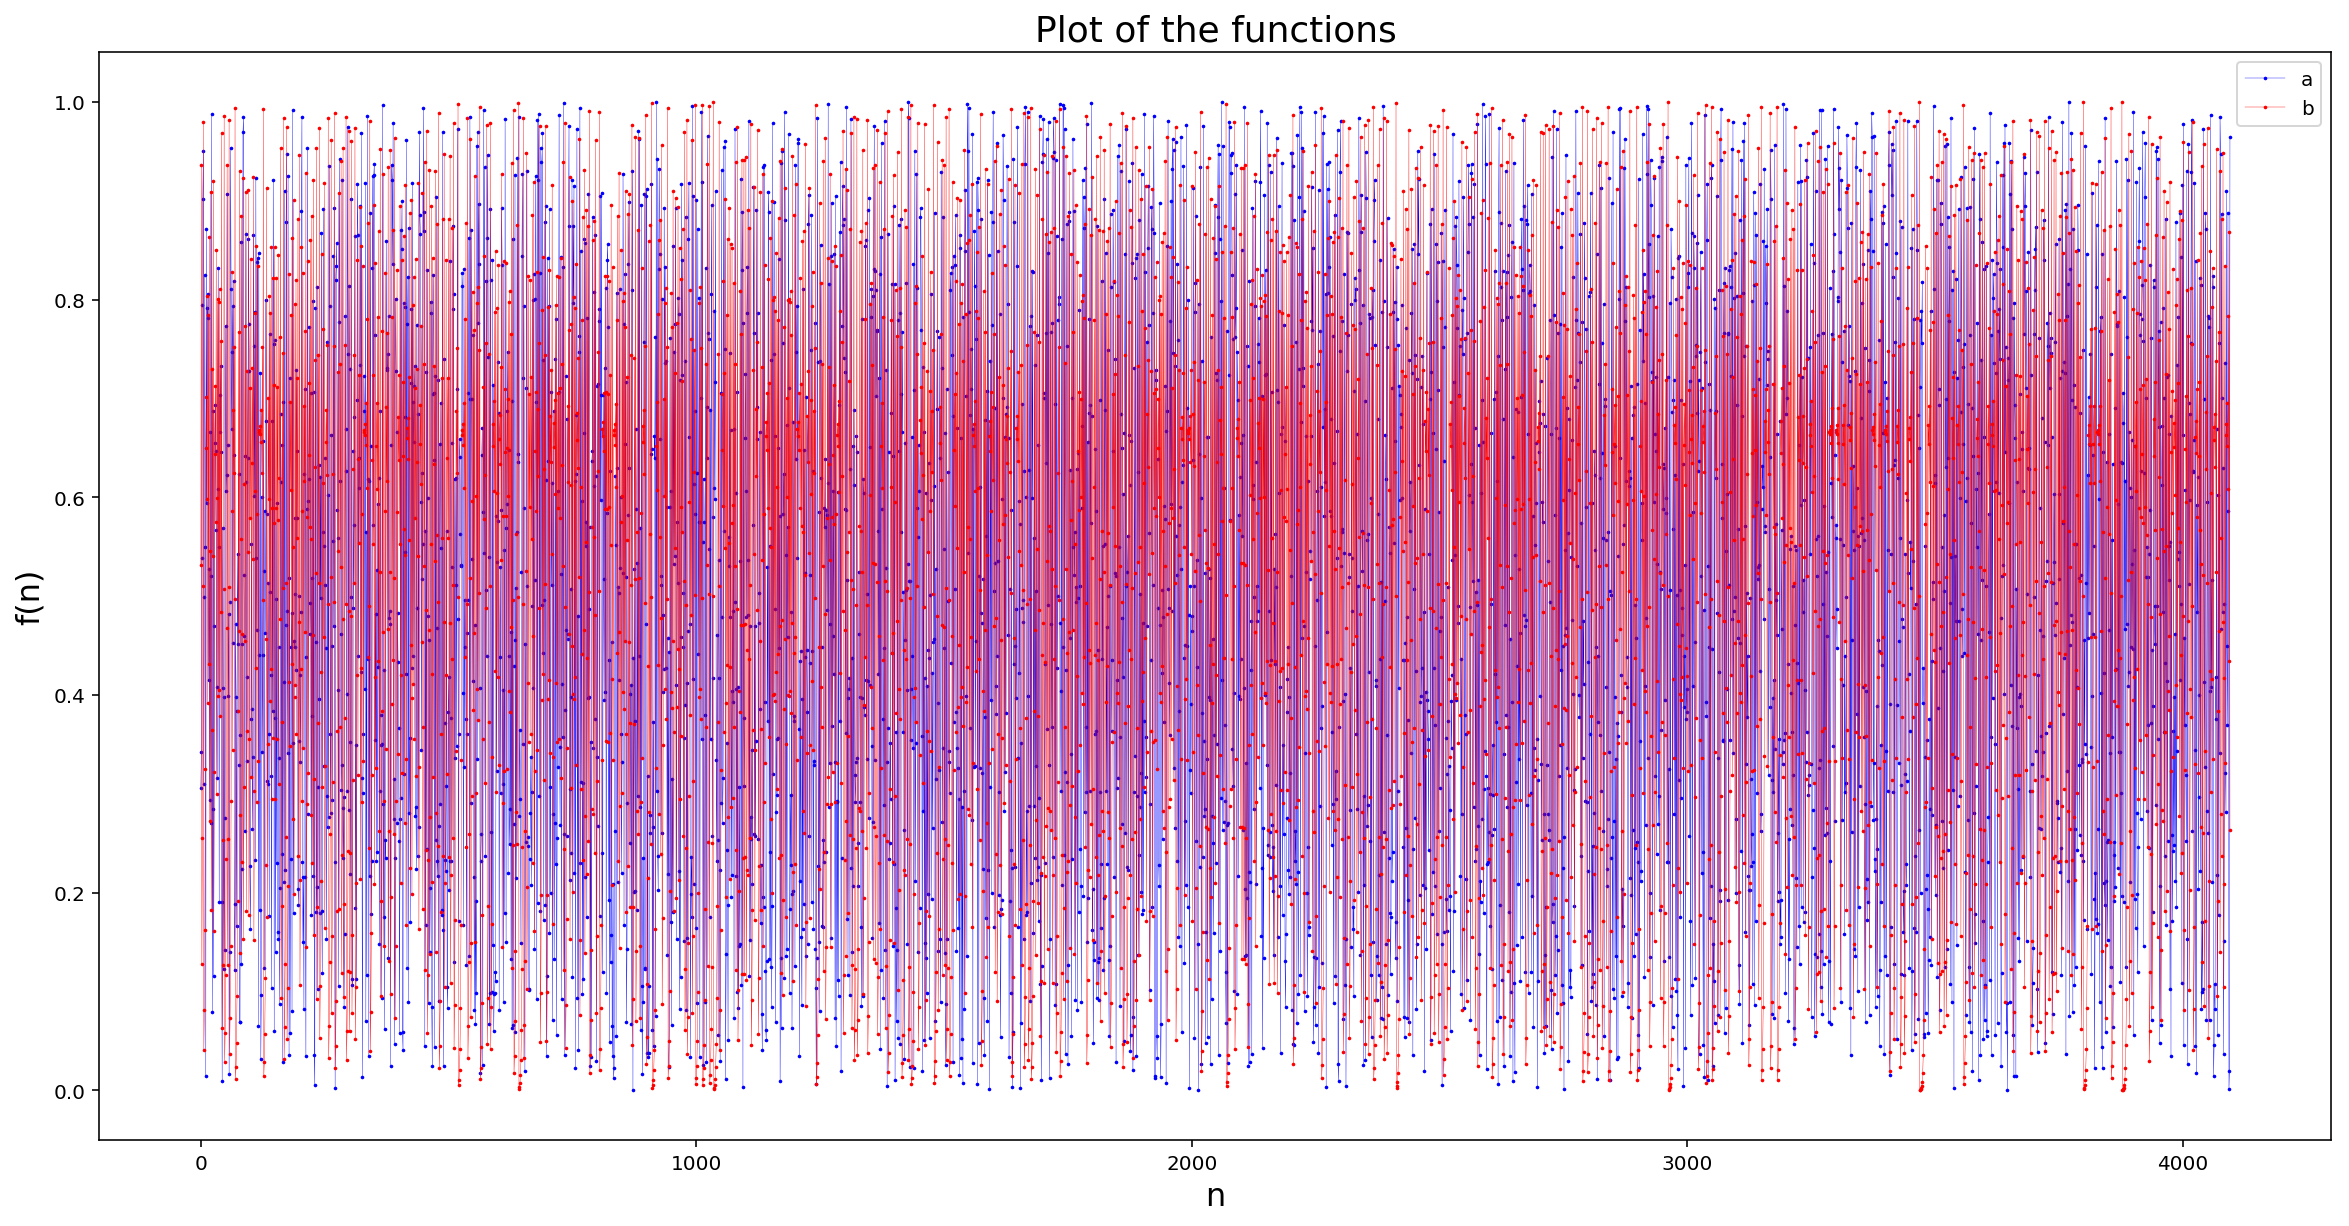

In [12]:
plt.figure(figsize=(20,10))
ns = [i for i in range(0, n)] #Sequence from 0 to 4096

plt.plot(ns, a, marker = 'o', color = 'blue', label = "a",  markersize = 0.8, linewidth = 0.2)
plt.plot(ns, b, marker = 'o', color = 'red', label = "b",  markersize = 0.8, linewidth = 0.2)
plt.title("Plot of the functions")
plt.xlabel("n")
plt.ylabel("f(n)")
plt.legend()
plt.show()

As we cannot really see a difference between the two functions, why not plotting a histogram? In this way, we can the distribution of both functions in the interval [0, 1].

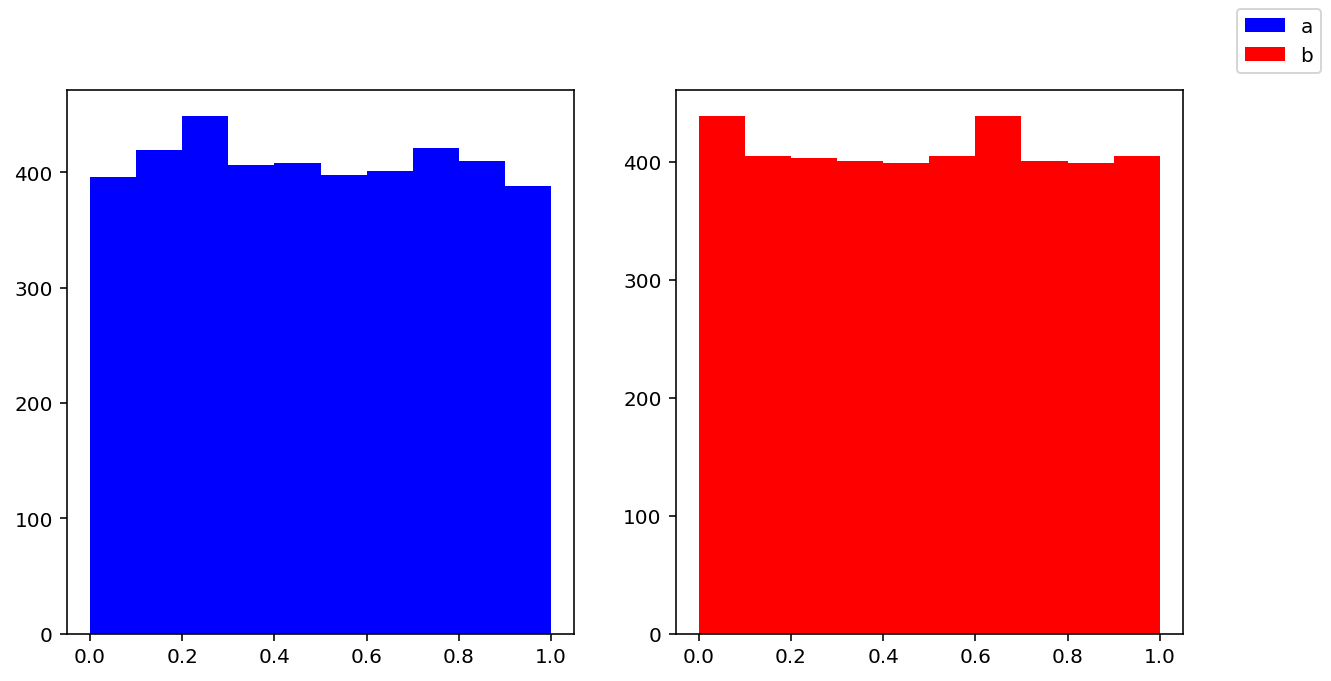

In [43]:
f, axs = plt.subplots(1,2,figsize=(10,5))

axs[0].hist(a, color = 'blue', label = "a")
axs[1].hist(b, color = 'red', label = "b")

f.legend()
plt.show()

Notice that the distribution of both graphs are basically a uniform distribution in the interval [0,1].

When you are suspicious that two functions are the same, what do you measure? If you ask a statistician (or if you see many biology or medicine papers), you would see that people like to measure **mean** and **variance** of the previous sequences. What do you think will happen with these measures?

Let us find out!

In [44]:
#Function that obtains the mean of a time series in a specific time interval
def vec_means(xs, h = 50):
    length_xs = np.size(xs)-1 #Length of vector minus 1
    length = int(np.floor(length_xs/h)) #Number of iterations of the cycle
    means, ns = np.zeros(length), np.zeros(length) #Initializes the vectors
    for i in range(0, length): #Cycle for adding elements to the vectors
        means[i] = np.mean(xs[i:i+h]) #Calling the mean function created above for that 
        #particular time bin
        ns[i] = i*h
    return means, ns #Returns the vector of means and the time

# Function that obtains the variances in different time windows
def vec_variance(xs, h = 10):
    length_xs = np.size(xs)-1
    length = int(np.floor(length_xs/h))
    variance, ns = np.zeros(length), np.zeros(length) 
    for i in range(0, length):
        variance[i] = np.var(xs[i:i+h])
        ns[i] = i*h
    return variance, ns

In [49]:
nn = 25 #For a time window of nn

#Means for both time series
ymean_a, xmean_a = vec_means(a, nn)
ymean_b, xmean_b = vec_means(b, nn)

#Variances for both time series
yvar_a, xvar_a = vec_variance(a, nn)
yvar_b, xvar_b = vec_variance(b, nn)

Instead of generating different plots like above, we will use subplots.

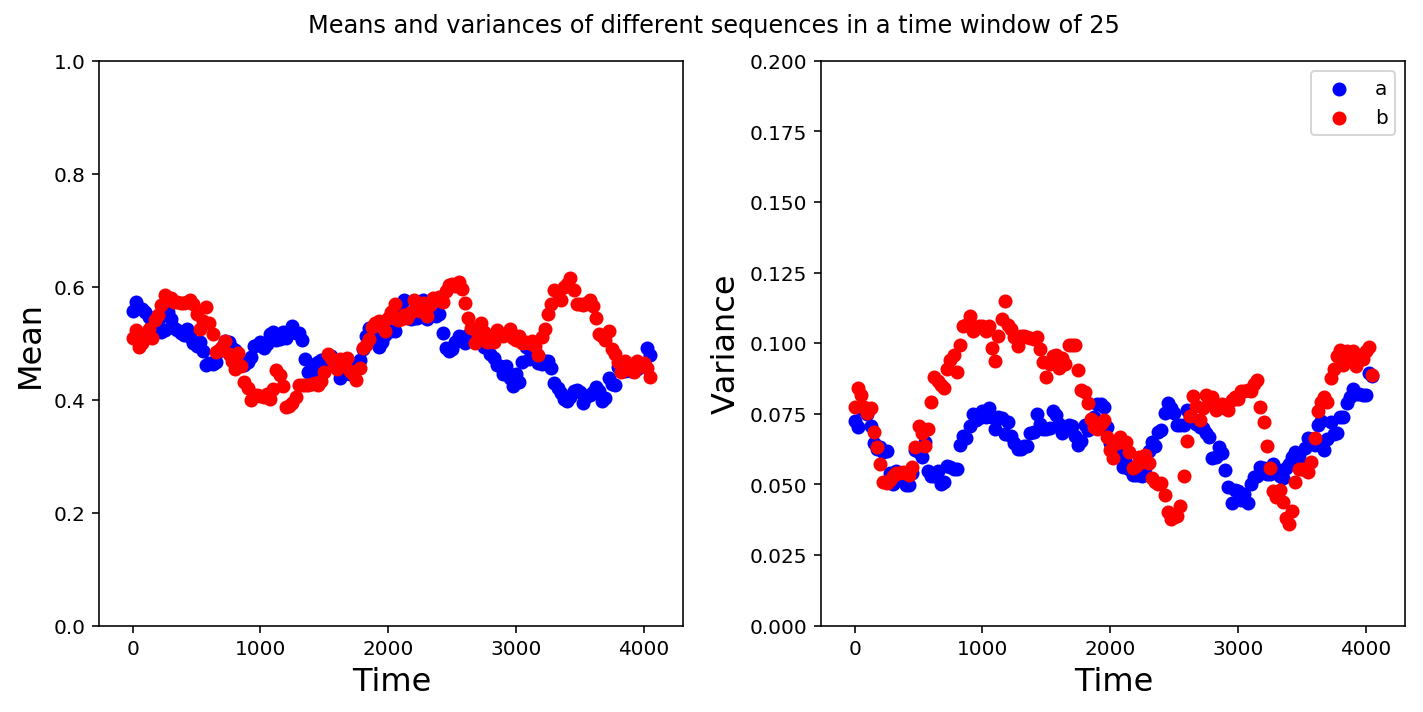

In [50]:
fig, axs = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('Means and variances of different sequences in a time window of '+str(nn)) 

axs[0].scatter(xmean_a, ymean_a, label = "a", marker = "o", color = "blue")
axs[0].scatter(xmean_b, ymean_b, label = "b", marker = "o", color = "red")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Mean")
axs[0].set_ylim([0, 1])
axs[0].set_title(" ")


axs[1].scatter(xvar_a, yvar_a, label = "a", marker = "o", color = "blue")
axs[1].scatter(xvar_b, yvar_b, label = "b", marker = "o", color = "red")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Variance")
axs[1].set_ylim([0, 0.2])

plt.tight_layout()
plt.legend()
plt.show()

Notice that both the means and variances look very similar in both sequences.

### Reconstruction of the function using the values $x_n$ and $x_{n+1}$

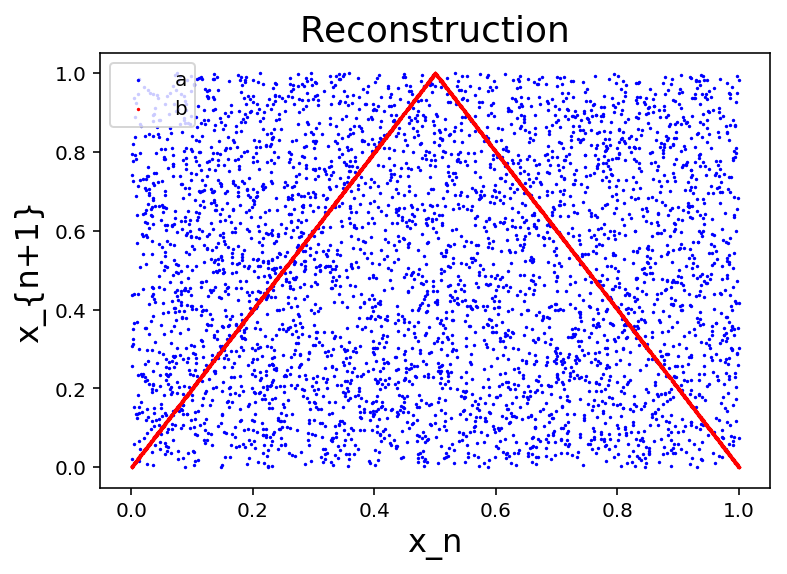

In [51]:
plt. scatter(a[0: n-1], a[1: n], color = "blue", label = "a", s = 0.5)
plt.scatter(b[0: n-1], b[1: n], color = "red", label = "b", s = 0.5)
plt.xlabel("x_n")
plt.ylabel("x_{n+1}")
plt.title("Reconstruction")
plt.legend()
plt.show()

Notice how in the first time series ($a$), we only plotted uniformly distributed random numbers. So there is no relationship between one value and the next one. No pattern emerges in the reconstructed phase space.

Neverthless, in the second time series, a pattern arises for the $b$ series. Notice that the deterministic evolution of $x_n$ where $x_0 = 0.1x_{n+1} = 1−2x^2_n$, measured through the nonlinear observation function $b = arccos(−x_n)/π$ gave way to a pattern. This pattern is known as the attractor which is reconstructed in phase space.

In this plot, the time delay we are considering is 1, in other words, $τ = 1$. Nevertheless, we could use another time delay, and the same (or would it be different?) pattern would emerge. Try it out!

## Exercise: Reconstruct the previous time series using a time delay of your election. For example, try a $τ = 9$ and see what happens!

# Henon map

A famous system of coupled equations is the Henon map. For more information, see: https://mathworld.wolfram.com/HenonMap.html
$$x_{n+1} = 1-ax_n^2 + y_n$$
$$y_{n+1} = bx_n$$

Where $a$ and $b$ are constants with values: $a= 1.4$ and $b = 0.3$.

Notice that given an initial value, we insert this in the system of equations and we obtain the next values. Then these values are inserted in the equations and we obtain the next ones. This process is repeated until we stop iterating.

In [52]:
# Defining the Henon function with the given values
#Notice that we are predefining the values of a and b
def henon(x, y, a=1.4, b=0.3):
    return [1-a*x**2+y, b*x]

In [53]:
x0 , y0 = 0.5, 0.5 #Starting in any point, the function will converge to the Henon map
n = 1000 #Number of iterations

#Initializing two vectors of zeros
xx = np.zeros(n)
yy = np.zeros(n)
xx[0], yy[0] = x0, y0 #The first two values of the sequence will be the startint point

for i in range(1, n): #Cycle for generating the henon map
    xx[i], yy[i] = henon(xx[i-1], yy[i-1])

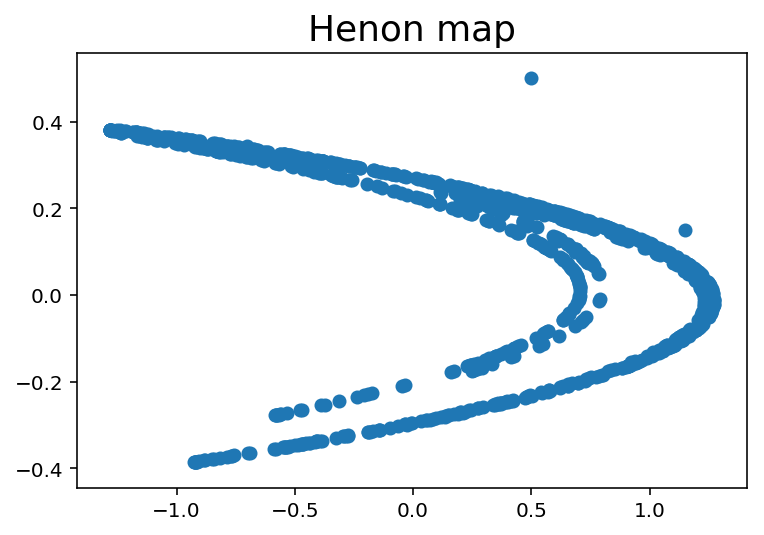

In [54]:
plt.scatter(xx, yy)
plt.title("Henon map")
plt.show()

Now, we reconstruct the attractor for the Henon map.

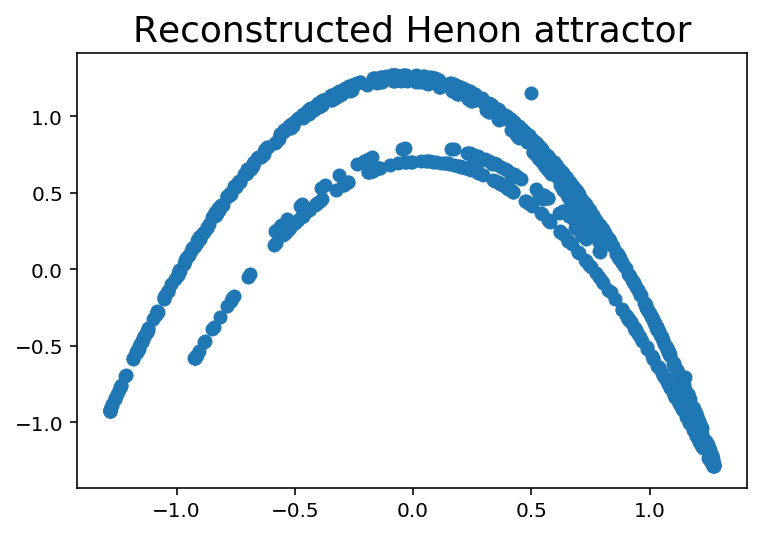

In [55]:
plt.scatter(xx[0:n-1], xx[1: n])
plt.title("Reconstructed Henon attractor")
plt.show()

# Exercise: Choose your favorite mathematic function and graph it. Afterwards, reconstruct its phase space using this time delay technique plotting the values $x_n$ and $x_{n+1}$

A suggestion is using the method given in the Henon map. Choose an initial value $x_0$ and insert it in your favorite mathematical function for obtaining the next value. Then insert this value in the function and repeat this process until you create a sequence of elements. Now, graph it and reconstruct the phase space.

Now that we are finally familiarized with reconstructing phase space, we will focus on reconstructing the heart's phase space.

# Heart phase space reconstruction in 2D

As the time delays are an arbitrary election, we can choose whichever we want! The only objective of this time lag is to unfold the dynamics of the attractor in phase space.

Let us generate a function that will reconstruct the phase space for a certain time delay. The time series we will be working with is the heart's change in voltage. In the following plots, the axes are $x_n$, which simply represents voltage.

In [56]:
#Generating a function that will reconstruct the phase space for a certain time delay
# data_series is the voltage of our signal
# period is the time delay
# identifier is a string that will help us identify that particular graph
def graph_one(data_series, period = 210, identifier = "xx"):
    time = period*0.1 #time is in miliseconds
    n = np.size(data_series) #size of the voltage vector
    
    plt.figure(2)
    plt. plot(data_series[0: n-period], data_series[period: n],
              marker = "o", markersize = 0.05, linewidth = 0.005, color = "black")
    plt.title(identifier+r": $t+"+str(time)+"ms$")
    plt.xlabel(r"$x_n$")
    y = r'$x_{n+'+str(time)+"ms}$"
    plt.ylabel(y)
    plt.show()
    return None

Trying out this function.

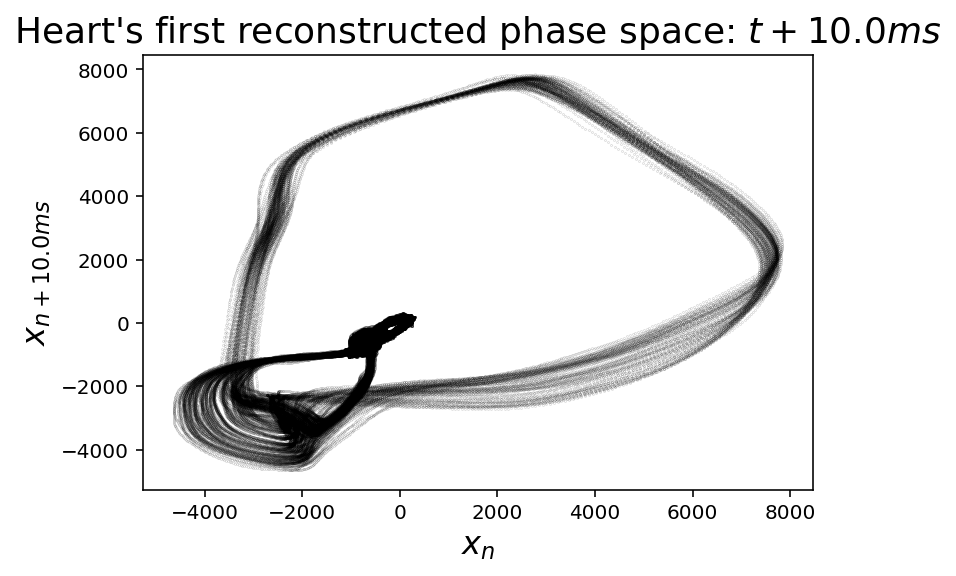

In [57]:
graph_one(waveData, 100, "Heart's first reconstructed phase space")

# Reproducing Petr Saparin’s work

Now that we saw that the function works, let us reproduce Petr Saparin’s work. These time delays are: 1.3 ms, 12.5 ms, 25 ms and 125 ms.

As there is no theoretically accurate time lag, people have used different time lags to study the heart attractor. In some studies, they use this time lag to be the 25% of the ventricular fibrillation cycle length, i.e. 25 ms [Umapathy et al., 2010,
pg. 109] [Gray et al., 1998, pg. 78]. In the following figure, we can see the reconstructed heart's phase space. Notice how every cycle lies in these well defined shapes. We can talk specifically about attractor recontruction in Saparin's work because of the clear dynamics in phase space. The figures below were made with the following time lags:

• Top left: τ = 1.25ms data is close to the diagonal because consecutive values are very similar.

• Top right: τ = 12.5ms large loop corresponds to QRS complex.

• Bottom left: τ = 25ms slower features like P and T waves.

• Bottom right: τ = 125ms complicated attractors.

<img src="Kantz_pg40.jpg" width ="400" height ="150" > 

The previous figure is taken from [Kantz and Schreiber, 2004, pg. 40]. Originally from Petr Saparin (1995).

In [81]:
def graphic_fun(data_series, time_delays = [13, 125, 250, 1250], identifier = "xx"):
    time = time_delays[0]*0.1
    n = np.size(data_series)
    fig, axs = plt.subplots(2,2,figsize=(9,9))
    
    st = fig.suptitle(identifier, fontsize="x-large")
    axs[0, 0].plot(data_series[0: n-time_delays[0]], data_series[time_delays[0]: n],
              marker = "o", markersize = 0.05, linewidth = 0.005, color = "black")
    axs[0, 0].set_title(r"$t+"+str(time)+"ms$")
    axs[0, 0].set_xlabel(r"$x_n$")
    y = r'$x_{n+'+str(time)+"ms}$"
    axs[0, 0].set_ylabel(y)
    
    time = time_delays[1]*0.1
    axs[0, 1].plot(data_series[0: n-time_delays[1]], data_series[time_delays[1]: n],
              marker = "o", markersize = 0.05, linewidth = 0.005, color = "black")
    axs[0, 1].set_title(r"$t+"+str(time)+"ms$")
    axs[0, 1].set_xlabel(r"$x_n$")
    y = r'$x_{n+'+str(time)+"ms}$"
    axs[0, 1].set_ylabel(y)
    
    time = time_delays[2]*0.1
    axs[1, 0].plot(data_series[0: n-time_delays[2]], data_series[time_delays[2]: n],
              marker = "o", markersize = 0.05, linewidth = 0.005, color = "black")
    axs[1, 0].set_title(r"$t+"+str(time)+"ms$")
    axs[1, 0].set_xlabel(r"$x_n$")
    y = r'$x_{n+'+str(time)+"ms}$"
    axs[1, 0].set_ylabel(y)

    time = time_delays[3]*0.1
    axs[1, 1].plot(data_series[0: n-time_delays[3]], data_series[time_delays[3]: n],
              marker = "o", markersize = 0.05, linewidth = 0.005, color = "black")
    axs[1, 1].set_title(r"$t+"+str(time)+"ms$")
    axs[1, 1].set_xlabel(r"$x_n$")
    y = r'$x_{n+'+str(time)+"ms}$"
    axs[1, 1].set_ylabel(y)

    #Shifts down the subplots
    fig.tight_layout()
    st.set_y(0.85)
    fig.subplots_adjust(top=0.8)
    return None

Trying out the previous function.

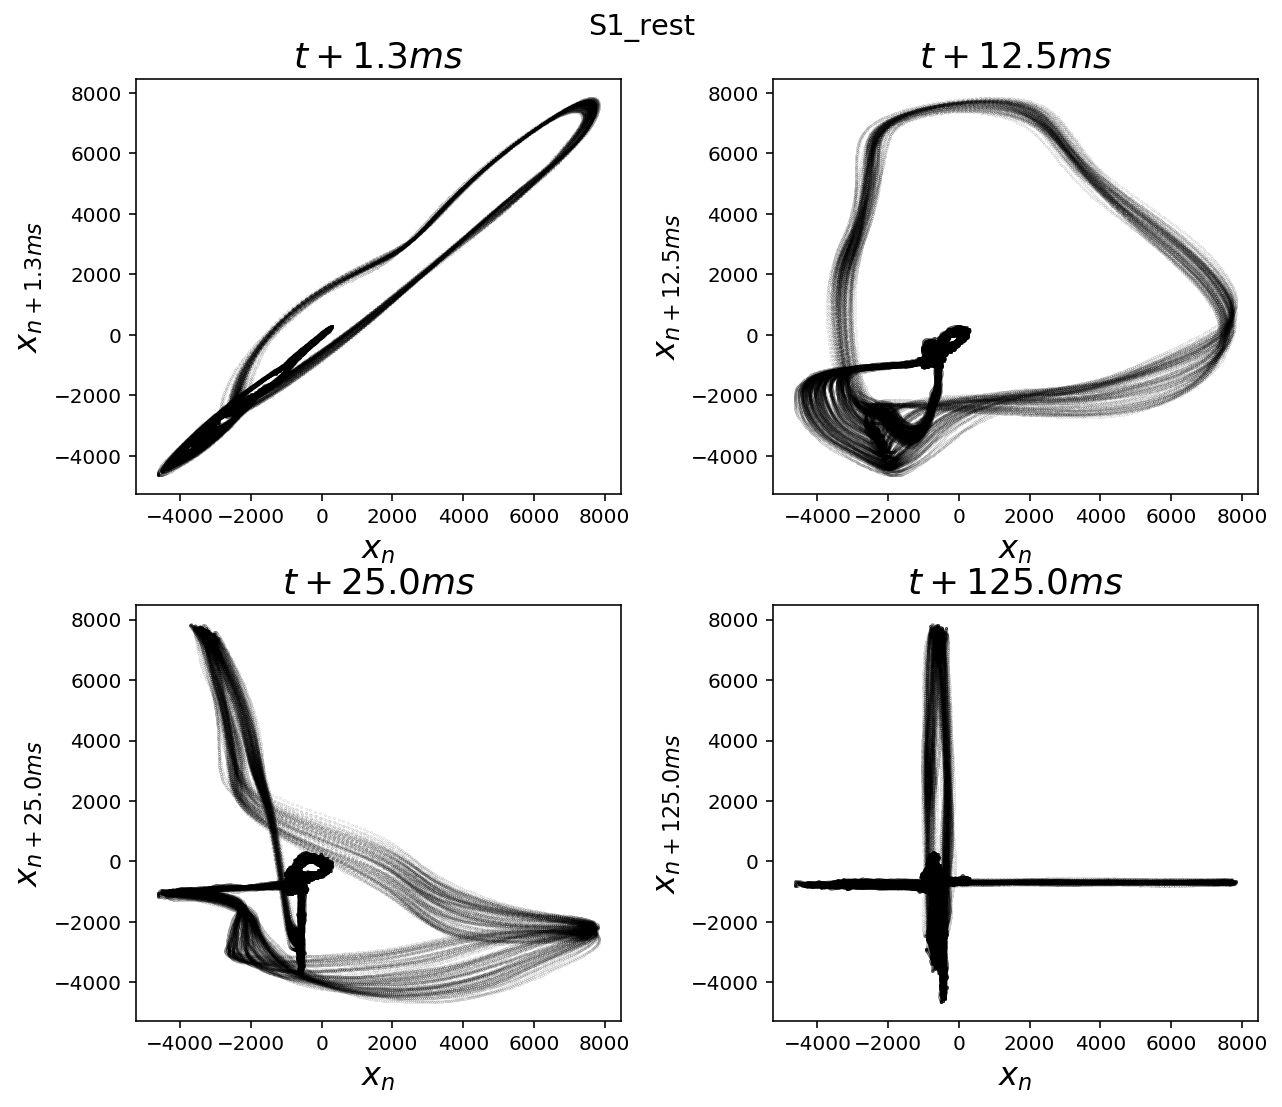

In [82]:
name = "S1_rest"
time_delays = [13, 125, 250, 1250]

timeEMG, waveData = ecg(name+".wav")
graphic_fun(waveData, time_delays, name)

# Rest vs. Exercise

Are you curious to see what happens to the phase space of a person after doing exercise? Try running the following code.

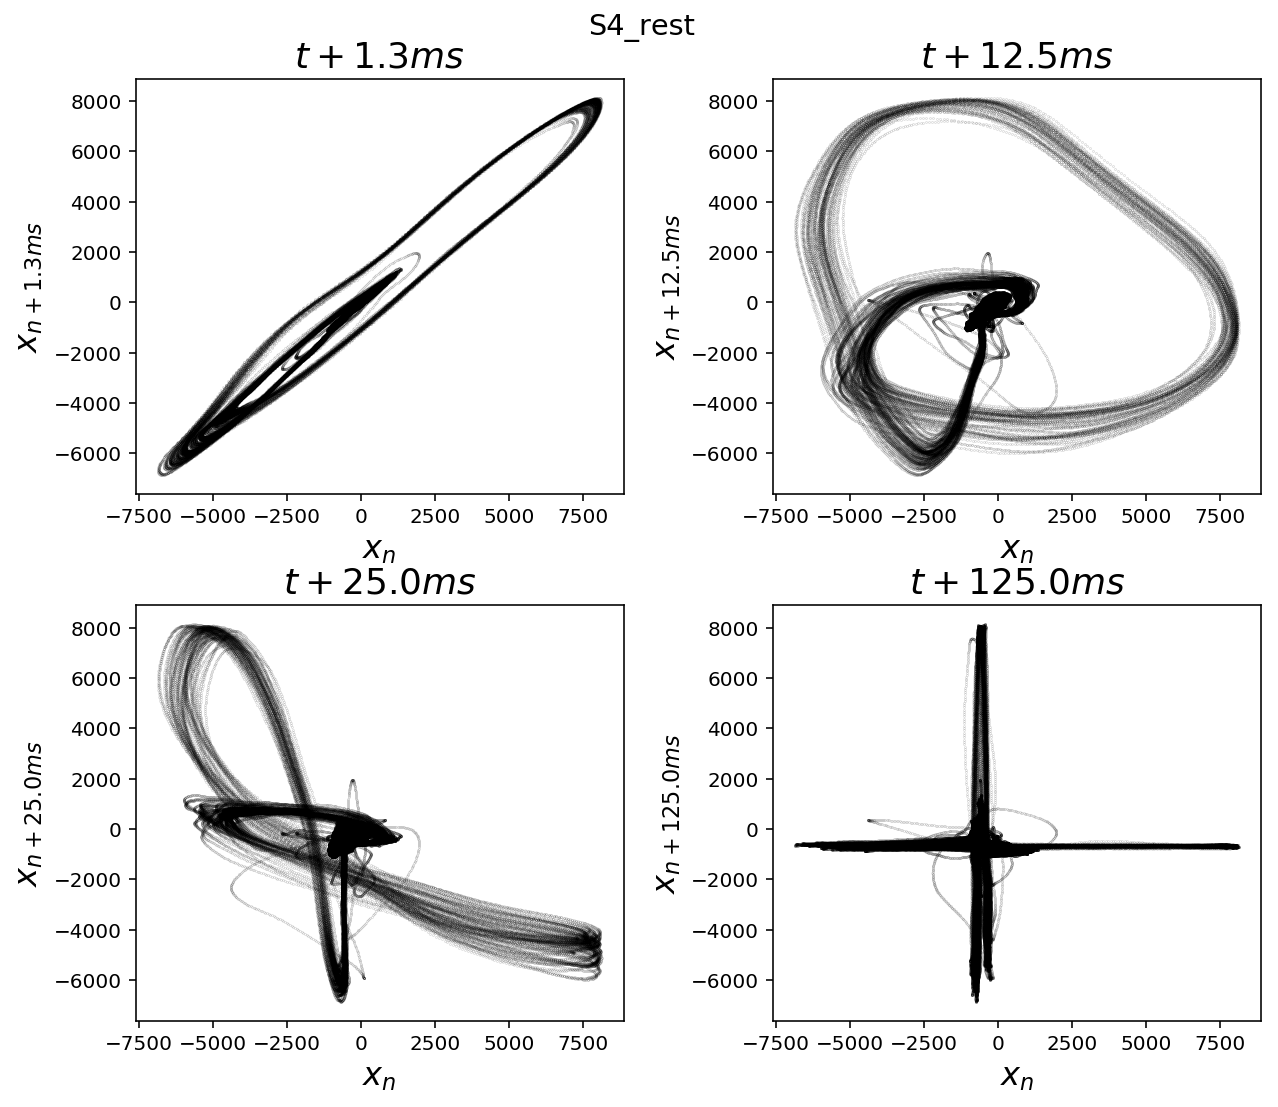

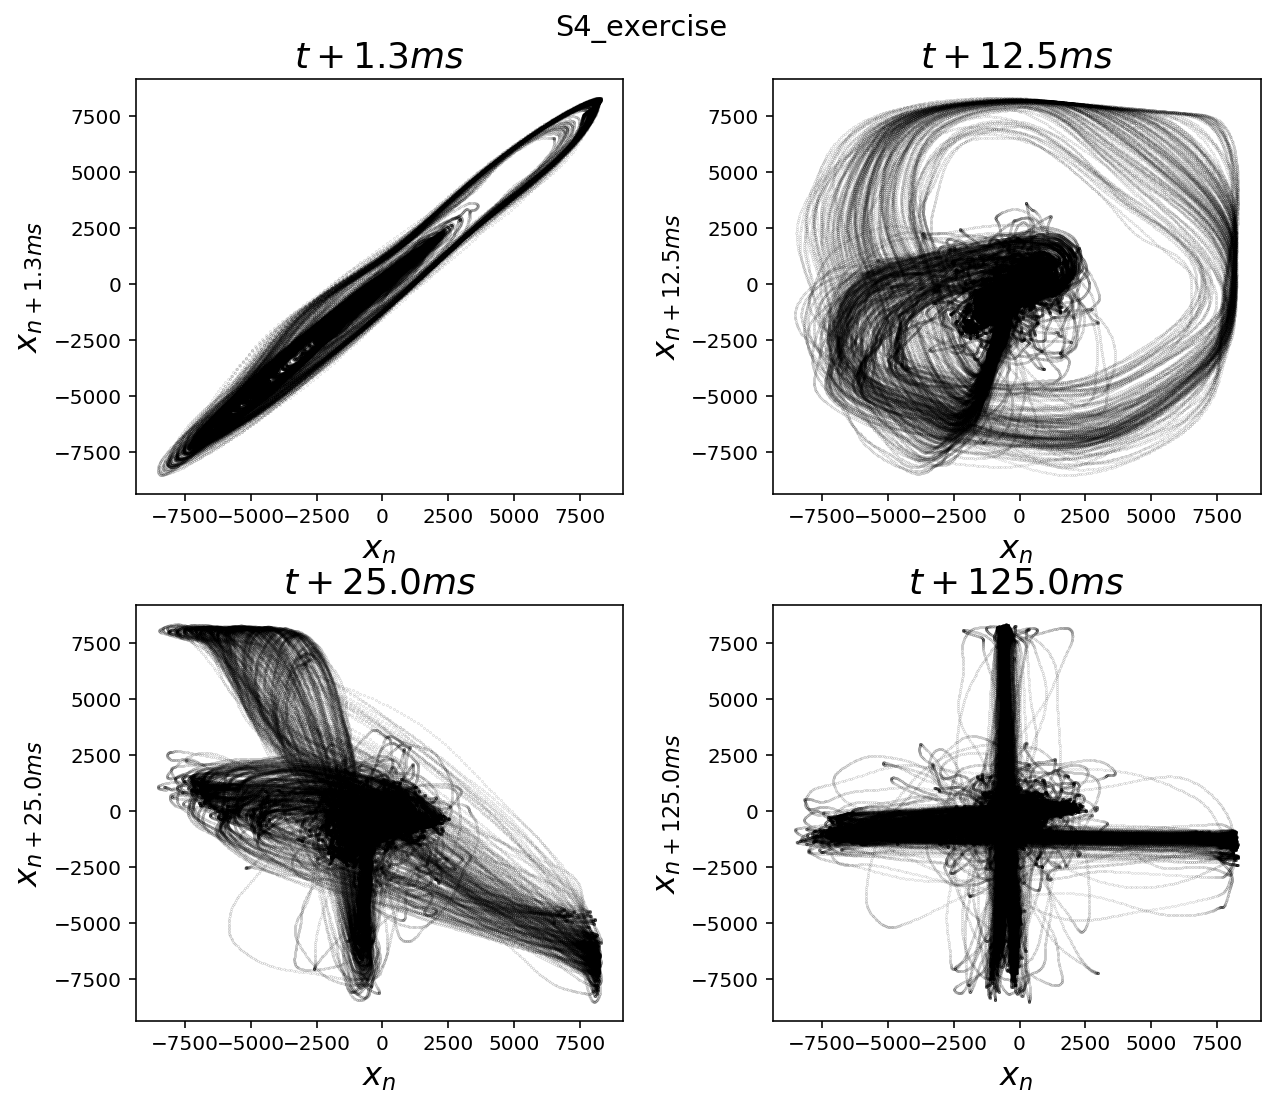

In [83]:
identifiers = ["S4_rest", "S4_exercise"]
time_delays = [13, 125, 250, 1250]

for i in range(0, np.size(identifiers)):
    timeEMG, waveData = ecg(identifiers[i]+".wav")
    graphic_fun(waveData, time_delays, identifiers[i])

The trayectories in phase space seem to have spread out after the individual does exercise. In other words, the trajectories seem to have a wider range of possibilities than in the resting state.

# Early indicator of heart disease?

Run the following code. Notice if there is any difference with the reconstructed phase spaces you have previously observed. 

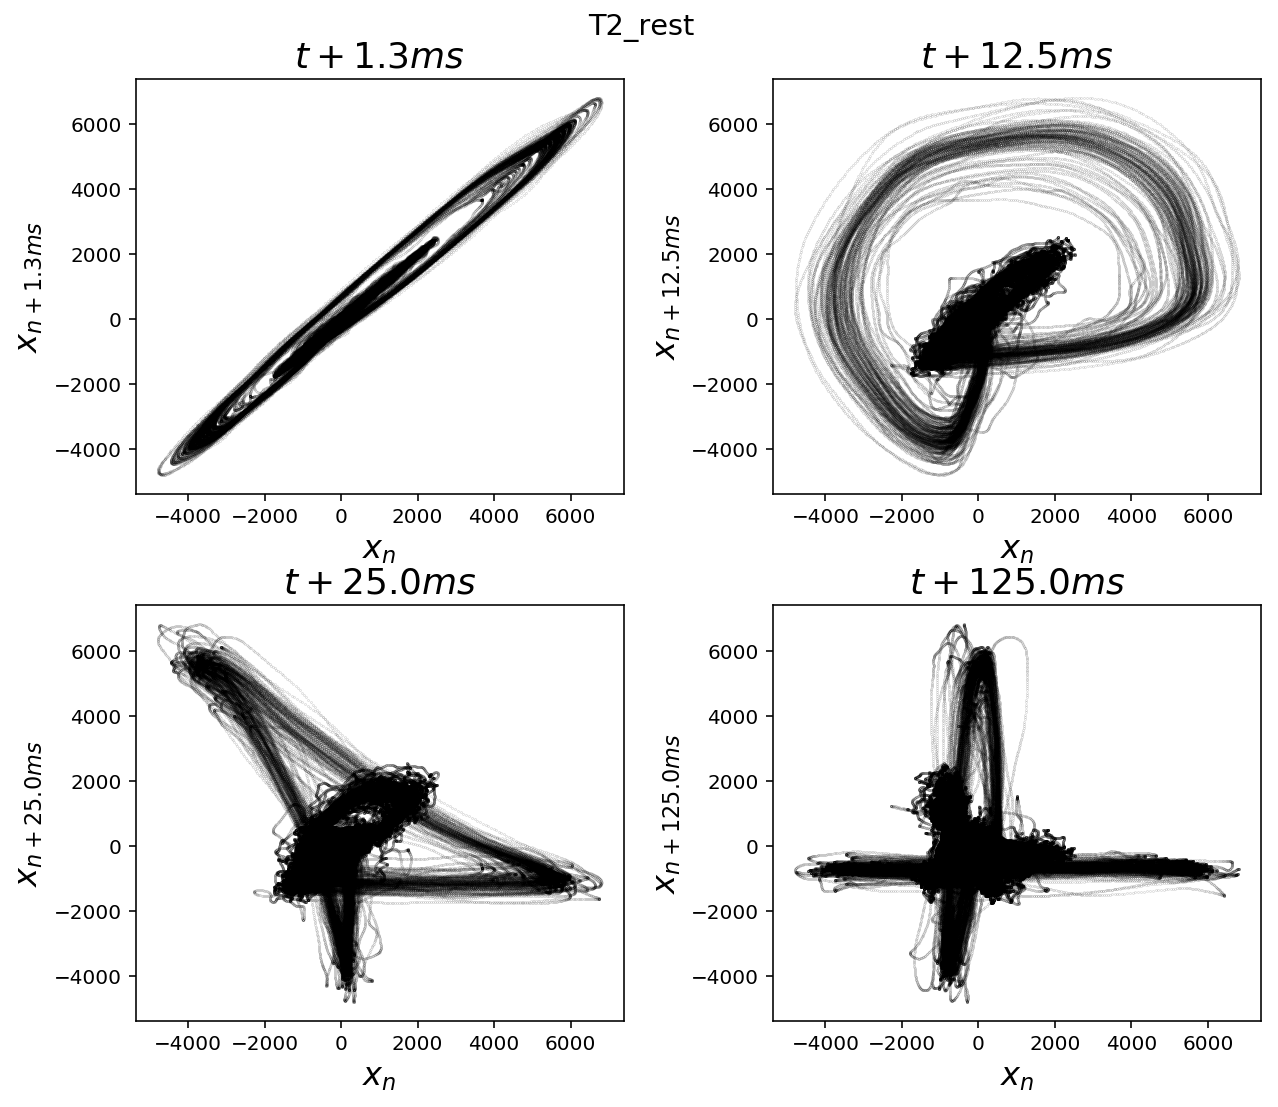

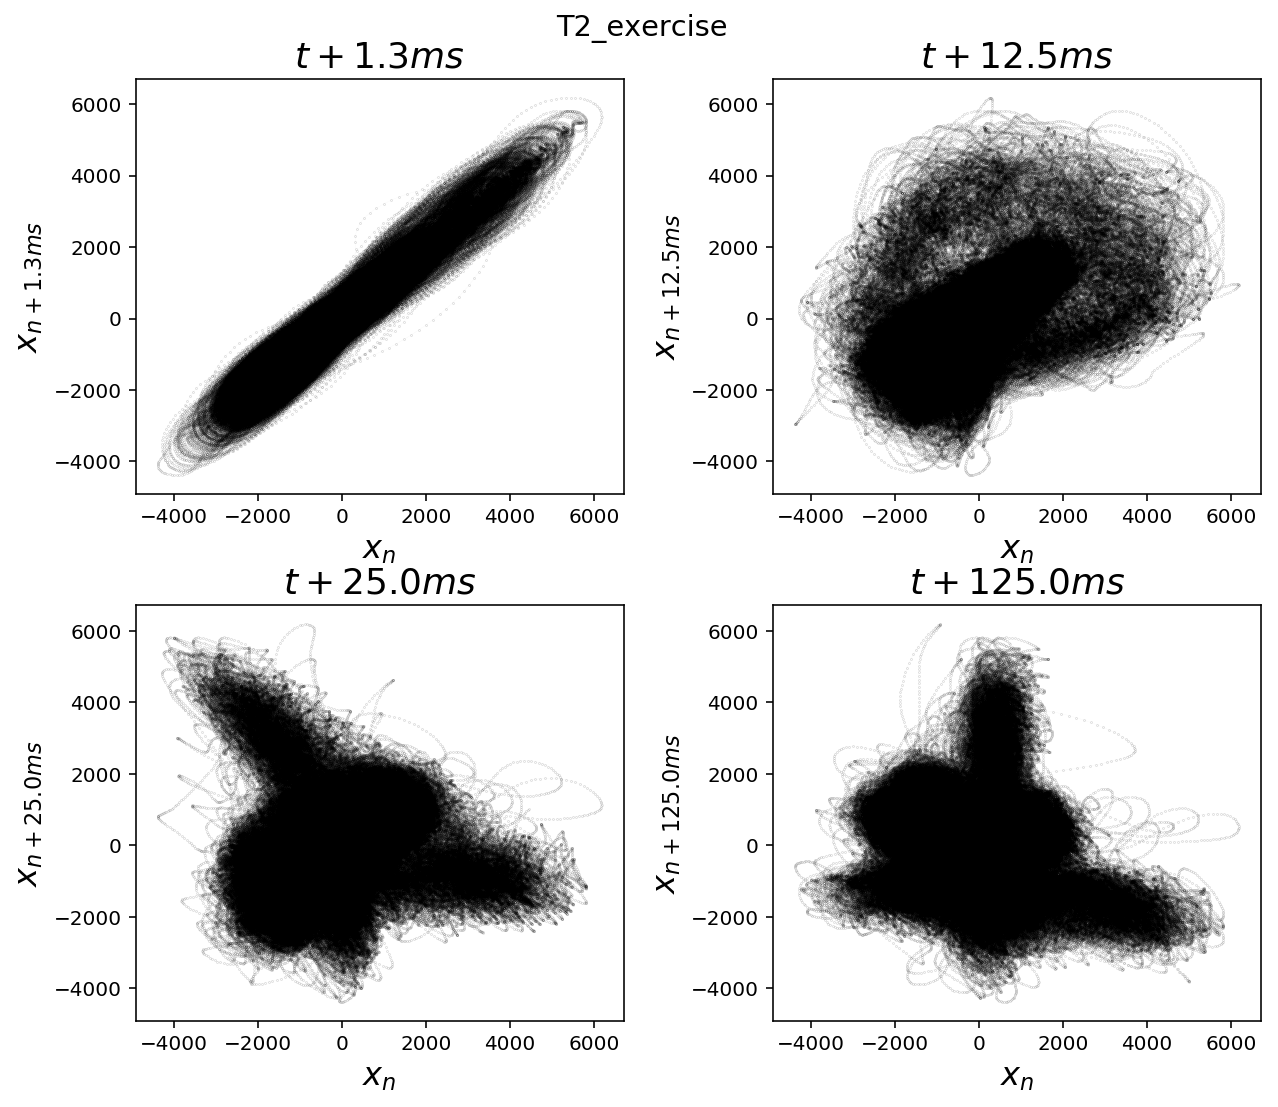

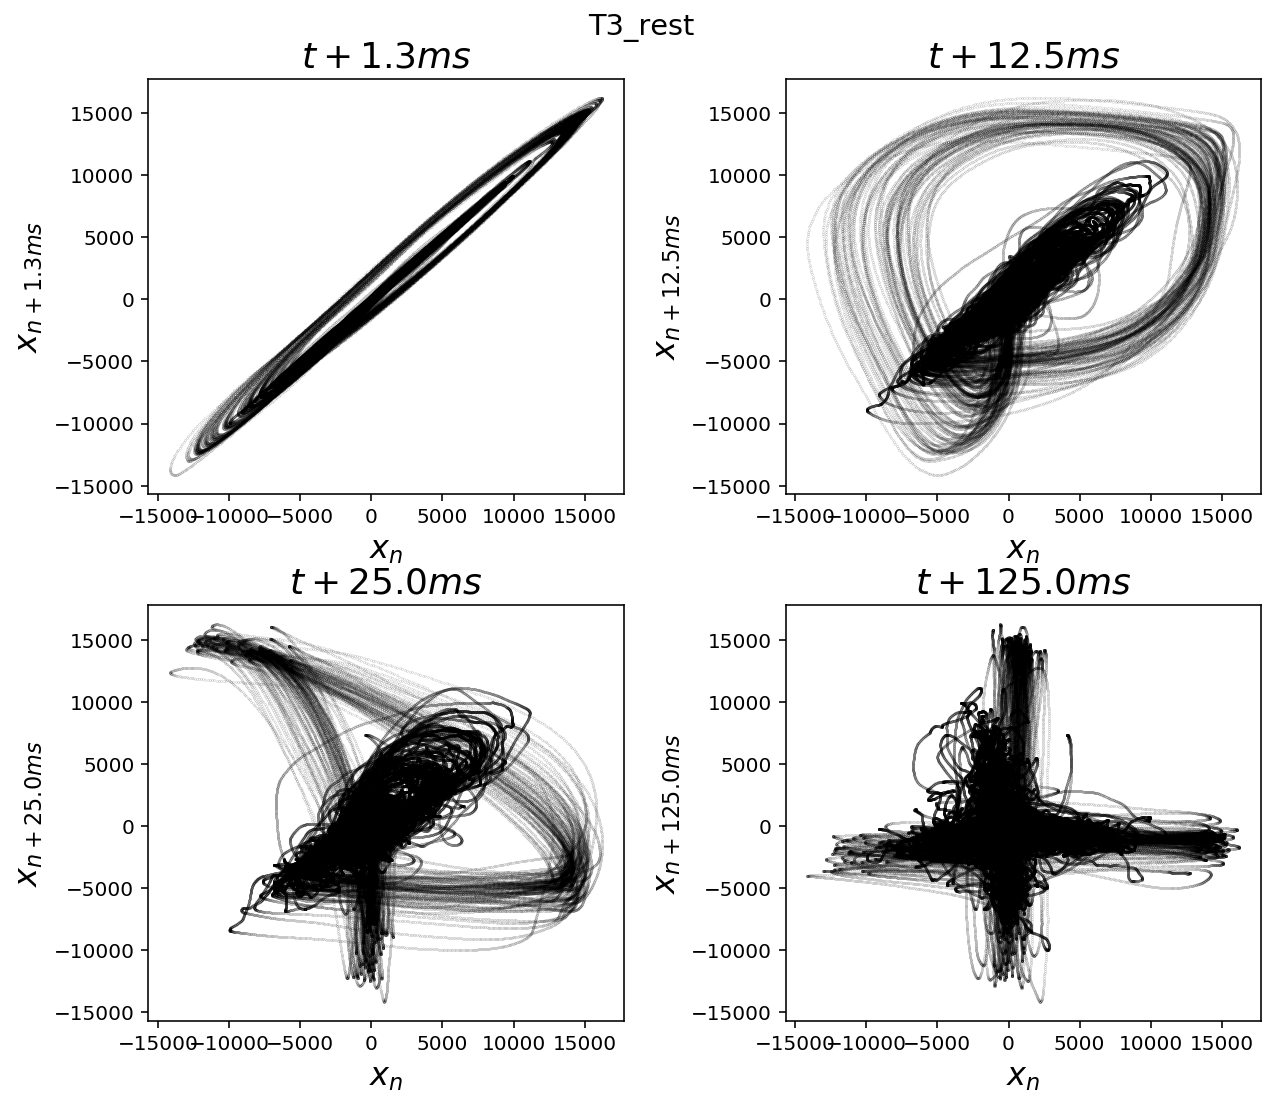

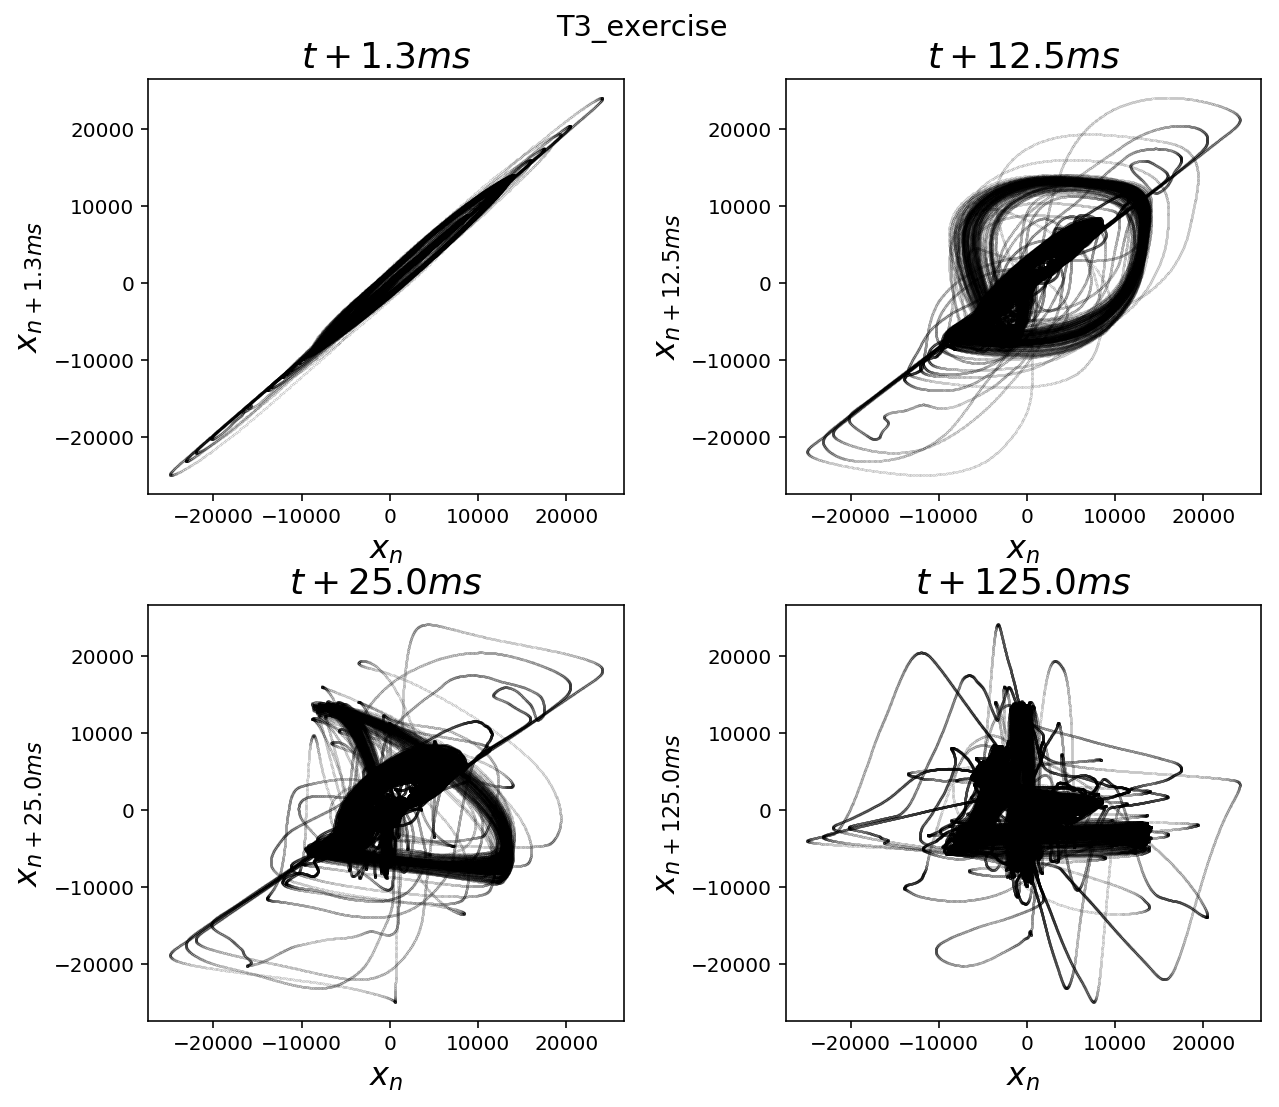

In [84]:
identifiers = ["T2_rest", "T2_exercise", "T3_rest", "T3_exercise"]
time_delays = [13, 125, 250, 1250]

for i in range(0, np.size(identifiers)):
    timeEMG, waveData = ecg(identifiers[i]+".wav")
    graphic_fun(waveData, time_delays, identifiers[i])

T2 is an individual who had the fastest heart rate of a group of around 6 people (*circa* 140 bpm after performing exercise). Notice how after doing exercise, the reconstructed phase space looks like a mass of uncorrelated dots. In this case, we cannot talk about an attractor because there is no defined shape in phase space which the heart follows each time. This could be thought of as an early indicator of heart disease.

T3 is an individual who had a prescription for consuming vasodilators, but did not take them. Notice how the dynamics of this heart changes after doing exercise. This is the only case where the scale for representing the heart’s dynamics doubles after performing exercise. This could be a case of how one type of cardiac arrhythmia looks in state space. Even though we know that this person has a heart condition, we cannot really say if the dynamics we are observing in the phase space is due to his condition or other variables. What we can say is that the dynamics in the recontructed phase space looks different than that of other recordings.

# Animations

In medicine, the duration of the QRS complex in a healthy heart is considered to be less than 12 ms [Szulewski, 2018]. Notice that when considering a time delay around this value, the dynamics in phase space unfolds i.e., the cycle is clearly visible.

<img src="ecg_and_attractor_rest.gif" width="750" align="center">

In [86]:
x, y = ecg("S1_rest.wav") #x is time and y is the voltage signal

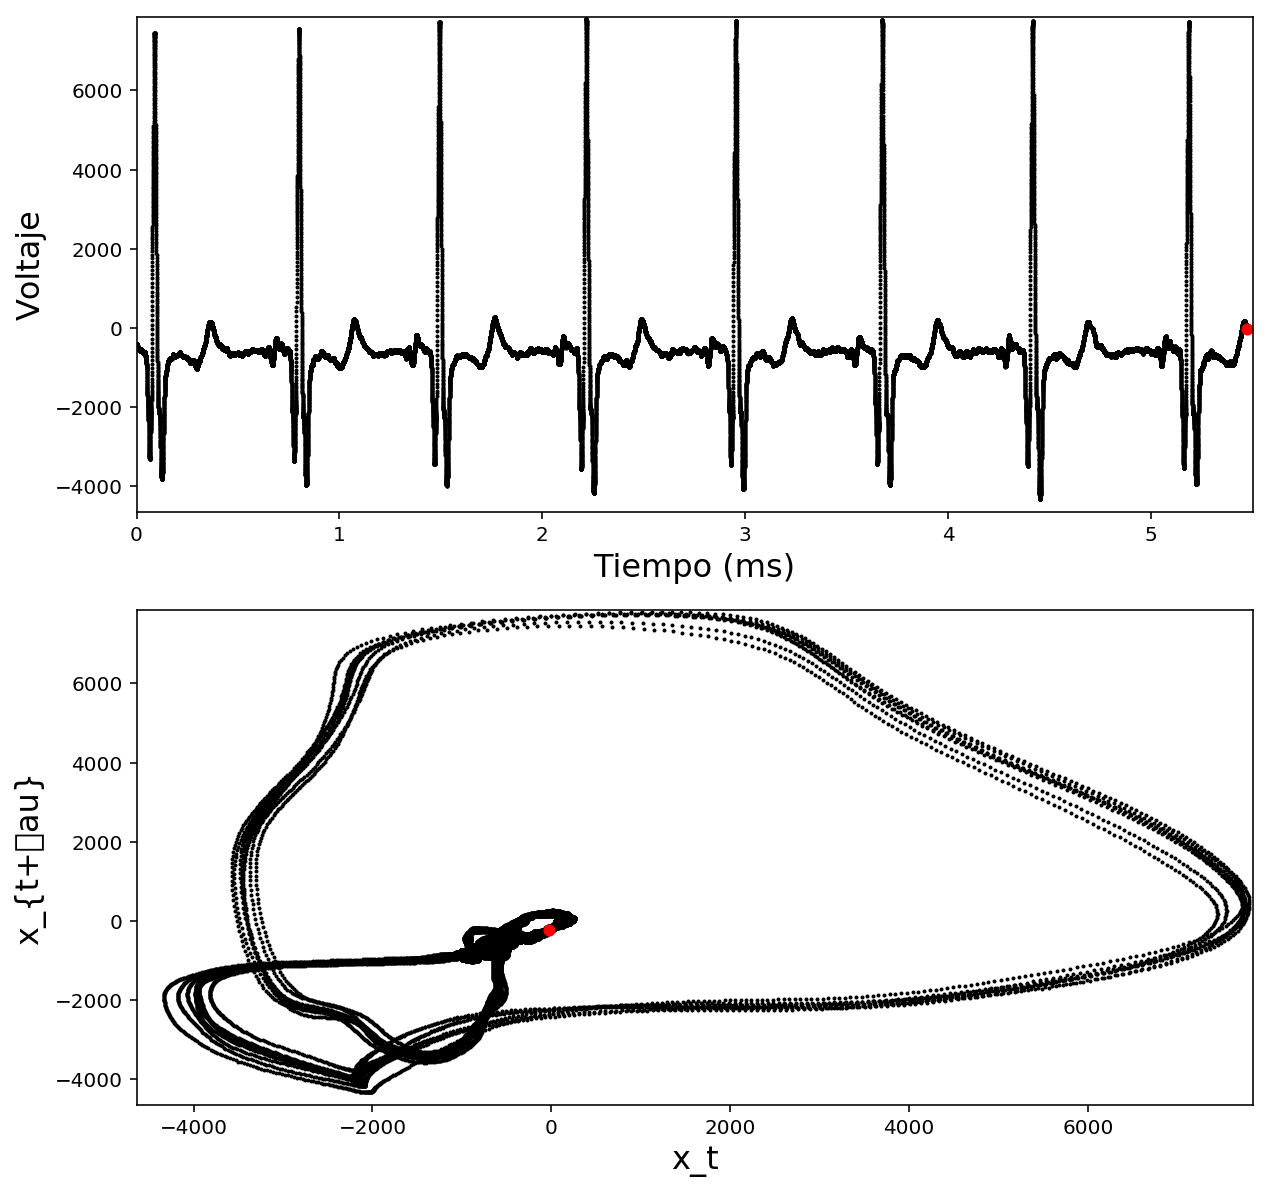

In [88]:
#https://pythonmatplotlibtips.blogspot.com/2018/01/combine-two-2d-animations-in-one-figure-
#matplotlib-artistanimation.html

period = 125 #Time delay for reconstructing pahse space
num_frames = 220 #Number of iterations for animation
steps = 250 #Number of steps the animation will skip for red marker

#Initializing the graphic space
fig = plt.figure(figsize=(9,9))

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)    

#ECG
ax1.set_ylabel('Voltage')
ax1.set_xlabel('Time (ms)')
ax1.set_xlim((0,x[steps*num_frames])),ax1.set_ylim((min(y),max(y))) 
ax1.set_ylim([min(y), max(y)])
trayectory_ecg, = ax1.plot([], [], 'k.', markersize=2)
particle_ecg, = ax1.plot([],[],'ro', markersize=5)

#Atractor reconstruido
ax2.set_xlabel(u'x_t')
ax2.set_ylabel(u'x_{t+tau}')
ax2.set_xlim([min(y), max(y)])
ax2.set_ylim([min(y), max(y)])
trayectory, = ax2.plot([],[],'k.', label="ecg", markersize = 2)
particle, = ax2.plot([],[],'ro', markersize=5)

def initialize():
    trayectory_ecg.set_data([],[])
    particle_ecg.set_data([],[])
    trayectory.set_data([],[])
    particle.set_data([],[])
    return(trayectory_ecg,particle_ecg,trayectory, particle)

def animate(i):
    trayectory_ecg.set_data(x[:i*steps], y[:i*steps])
    particle_ecg.set_data(x[i*steps],y[i*steps])   
    trayectory.set_data(y[:i*steps], y[period:i*steps+period])
    particle.set_data(y[i*steps],y[i*steps+period])    
    return(trayectory_ecg,particle_ecg,trayectory, particle)

anim = animation.FuncAnimation(fig, animate, init_func=initialize,
                               frames=num_frames, interval=40, blit=True)

anim.save('ecg_and_phase_space_rest.gif', writer='pillow')

What do you think will happen to the phase space after performing exercise?

In [35]:
x, y = ecg("S1_exercise.wav") #x is time and y is the voltage signal

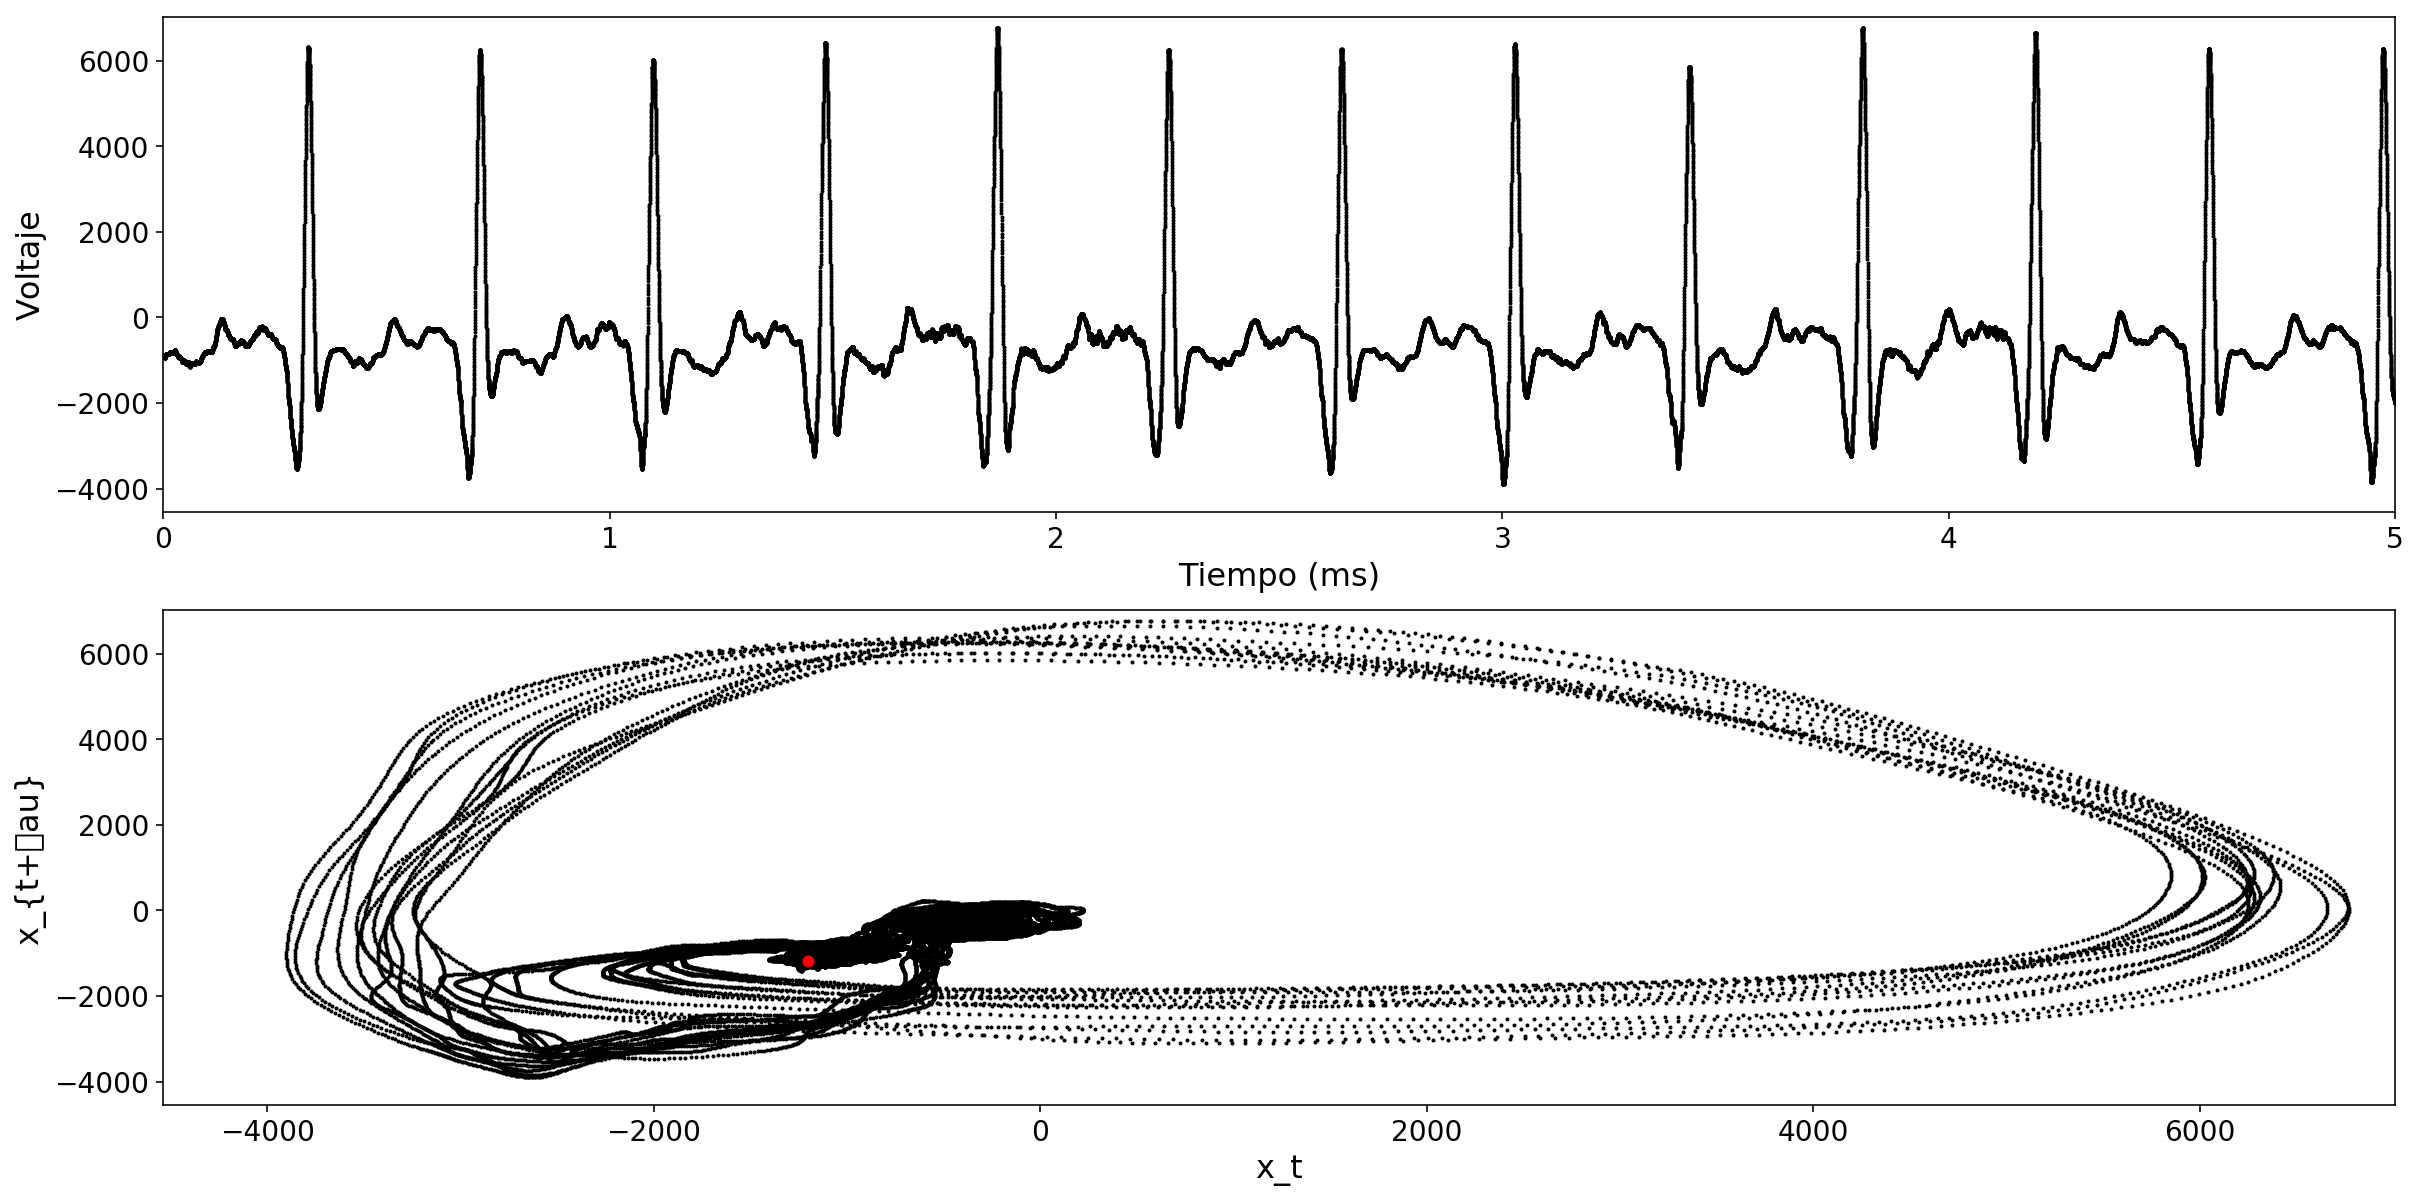

In [36]:
#https://pythonmatplotlibtips.blogspot.com/2018/01/combine-two-2d-animations-in-one-figure-
#matplotlib-artistanimation.html

period = 125 #Time delay for reconstructing phase space
num_frames = 220 #Number of iterations for animation
steps = 250 #Number of steps the animation will skip for red marker

#Initializing the graphic space
fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)    

#ECG
ax1.set_ylabel('Voltage')
ax1.set_xlabel('Time (ms)')
ax1.set_xlim([0, 5])
ax1.set_ylim([min(y), max(y)])
trayectory_ecg, = ax1.plot([], [], 'k.', markersize=2)
particle_ecg, = ax1.plot([],[],'ro', markersize=5)

#Atractor reconstruido
ax2.set_xlabel(u'x_t')
ax2.set_ylabel(u'x_{t+tau}')
ax2.set_xlim([min(y), max(y)])
ax2.set_ylim([min(y), max(y)])
trayectory, = ax2.plot([],[],'k.', label="ecg", markersize = 2)
particle, = ax2.plot([],[],'ro', markersize=5)

def initialize():
    trayectory_ecg.set_data([],[])
    particle_ecg.set_data([],[])
    trayectory.set_data([],[])
    particle.set_data([],[])
    return(trayectory_ecg,particle_ecg,trayectory, particle)

def animate(i):
    trayectory_ecg.set_data(x[:i*steps], y[:i*steps])
    particle_ecg.set_data(x[i*steps],y[i*steps])   
    trayectory.set_data(y[:i*steps], y[period:i*steps+period])
    particle.set_data(y[i*steps],y[i*steps+period])    
    return(trayectory_ecg,particle_ecg,trayectory, particle)

anim = animation.FuncAnimation(fig, animate, init_func=initialize,
                               frames=num_frames, interval=40, blit=True)

anim.save('ecg_and_phase_space_exercise.gif', writer='pillow')

See the folder where this notebook is for playing the animations you just created.

# Heart's phase space reconstruction in 3D

We limit the reconstructed phase space to a 2 dimensional space because it is what we can visualize in a screen. Nevertheless, we know that it is N-dimensional. With current computer software, we can recreate some 3D graphs of this pahse space. The time delays used here are all the possible combinations of the time delays used for the 2D graphs created above. This individual had a healthy and active lifestyle. The recording is at a resting state.

If you are not familiar with graphing in 3 dimensions, you might want to take a look at the following link: https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html

In [89]:
#This line of code will allow you to move the 3D plots to see them from any angle!
#3d plot manipulation
%matplotlib notebook

In [92]:
def graph_3d(data_series, period1, period2): #Making graphs in 3D for phase space
    # The vectors should be of the same size, so the last elements will be deleted in case 
    #there are extra for a certain vector
    time1 = round(period1*0.1, 2)
    time2 = round(period2*0.1, 2)
    
    n = np.size(data_series)
    x = data_series[0: n-period2]
    y = data_series[period1: n-(period2-period1)]
    z = data_series[period2: n]    
    
    fig = plt.figure(figsize=(5,5))
    ax = fig.gca(projection='3d')
    ax.set_xlabel(r"$x_n$")
    ax.set_ylabel(r'$x_{n+'+str(time1)+"ms}$")
    ax.set_zlabel(r'$x_{n+'+str(time2)+"ms}$")
    ax.plot(x, y, z, marker = "o", markersize = 0.05, linewidth = 0.005, color = "black")
    lbl = r'Phase space with $t_{' + str(time1) +"}$ and $t_{"+ str(time2) + "}$ ms"
    plt.title(lbl)
    plt.show()
    
    return None

Trying the previous function.

<IPython.core.display.Javascript object>


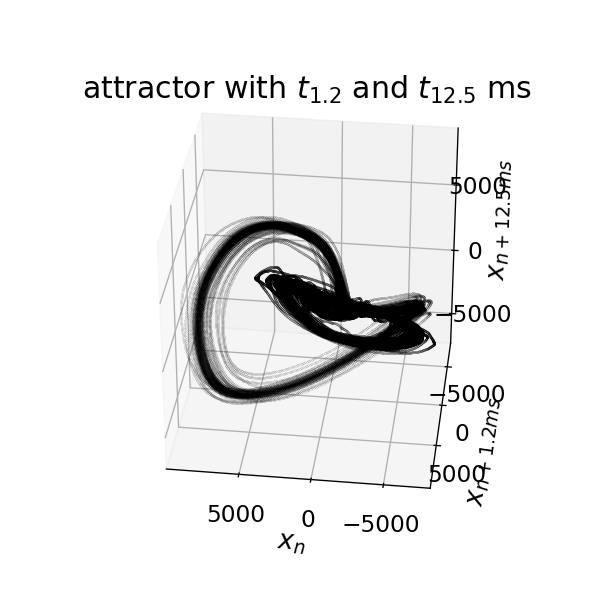

In [93]:
timeEMG, waveData = ecg("T1_rest.wav")
graph_3d(waveData, 12, 125)

Now, we want a single function that plots various combinations of graphs.

In [112]:
def graphi_many_3d(time_delays = [13, 125, 250, 1250], identifier = "xx"):
    
    timeEMG, data_series = ecg(identifier)
    n = np.size(data_series)
    
    fig = plt.figure(figsize=(7.5, 6))
    counter = 1
    
    for i in time_delays:
        for j in time_delays:
            if i != j and i < j: #Each pair of possible combiantions with no repeats
                time1 = round(i*0.1, 2)
                time2 = round(j*0.1, 2)

                n = np.size(data_series)
                x = data_series[0: n-j]
                y = data_series[i: n-(j-i)] #Notice that j>i always, so no need for abs
                z = data_series[j: n]
                
                a = 230+counter
                
                ax = fig.add_subplot(a, projection='3d')
                ax.set_xlabel(r"$x_n$")
                ax.set_ylabel(r'$x_{n+'+str(time1)+"ms}$")
                ax.set_zlabel(r'$x_{n+'+str(time2)+"ms}$")
                ax.plot(x, y, z, marker = "o", markersize = 0.05, linewidth = 0.005, \
                        color = "black")
                lbl = r'$t_{' + str(time1) +"}$ and $t_{"+ str(time2) + "}$ ms"
                ax.set_title(lbl)
                counter += 1
    fig.tight_layout()
    plt.show()
    return None

<IPython.core.display.Javascript object>


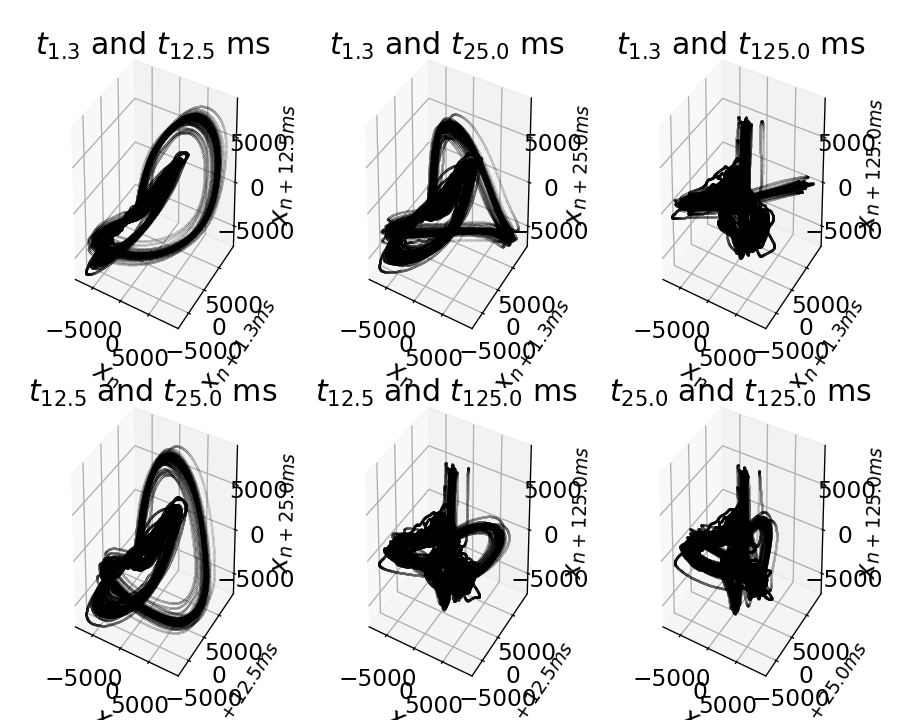

In [113]:
graphi_many_3d([13, 125, 250, 1250], "T1_rest.wav")

Now, what do you think will happen to the heart's phase space after this person does exercise? 

<IPython.core.display.Javascript object>


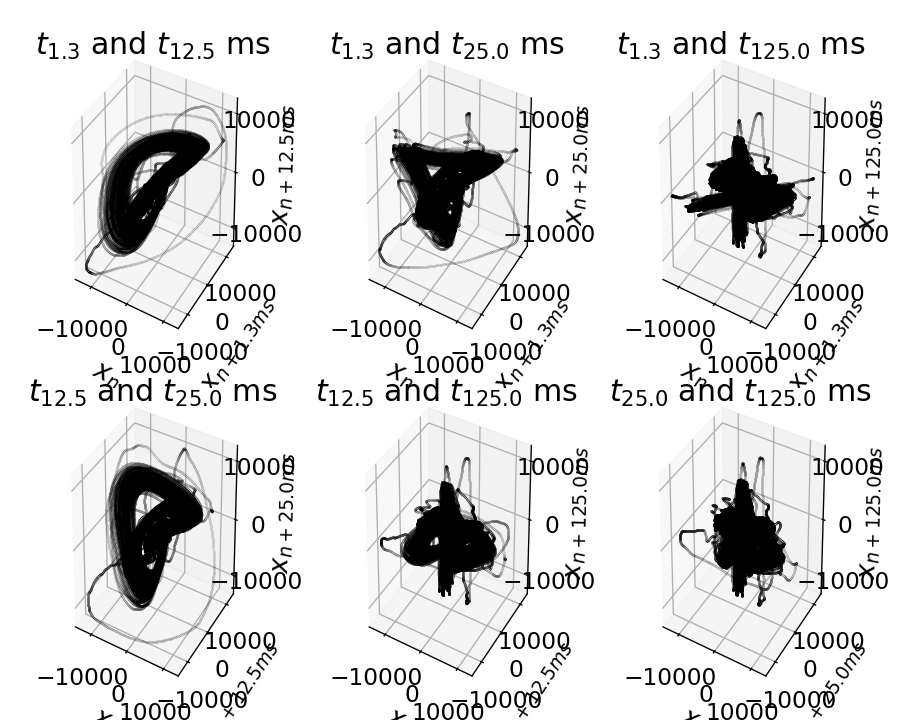

In [114]:
graphi_many_3d([13, 125, 250, 1250], "T1_exercise.wav")

# Have fun analyzing the recordings!

In [34]:
#Test data
identifiers = ["S1_rest", "S1_exercise", "S2_rest", "S2_exercise",
               "S3_rest", "S3_exercise", "S4_rest", "S4_exercise",
               "T1_rest_5s", "T1_rest", "T1_exercise", "T2_rest", "T2_exercise",
               "T4_rest", "T4_exercise", "T3_rest", "T3_exercise"]

# References

[Aston et al., 2018] Aston, P. J., Christie, M. I., Huang, Y. H., and Nandi, M. (2018). Beyond hrv: attractor reconstruction using the entire cardiovascular waveform data for novel feature extraction. Physiological measurement, 39(2):024001.

[BackyardBrains, 2017] BackyardBrains (2009-2017). Experiment: Heart Action Potentials. https://backyardbrains.com/experiments/heartrate. Accessed December 20, 2019.

[Boron and Boulpaep, 2012] Boron, W. F. and Boulpaep, E. L. (2012). Medical physiology, 2e updated edition e-book: with student consult online access. Elsevier health sciences.

[Charlton et al., 2015] Charlton, P. H., Camporota, L., Smith, J., Nandi, M., Christie, M., Aston, P. J., and Beale, R. (2015). Measurement of cardiovascular state using attractor reconstruction analysis. In 2015 23rd European Signal Processing Conference (EUSIPCO), pages 444–448. IEEE.

[Gray et al., 1998] Gray, R. A., Pertsov, A. M., and Jalife, J. (1998). Spatial and temporal organization during cardiac fibrillation. Nature, 392(6671):75.

\*[Kantz and Schreiber, 2004] Kantz, H. and Schreiber, T. (2004). Nonlinear time series analysis, volume 7. Cambridge university press.

[Parker and Chua, 2012] Parker, T. S. and Chua, L. (2012). Practical numerical algorithms for chaotic systems. Springer Science & Business Media.

\*[Sauer et al., 1991] Sauer, T., Yorke, J. A., and Casdagli, M. (1991). Embedology. Journal of statistical Physics, 65(3-4):579–616.

[Sauer, 2006] Sauer, T. D. (2006). Attractor reconstruction. Scholarpedia, 1(10):1727. revision #91017.

[Savi, 2005] Savi, M. (2005). Chaos and order in biomedical rhythms. Journal of the Brazilian Society of Mechanical Sciences and Engineering, 27(2):157–169.

\*[Srinivasan et al., 2003] Srinivasan, N., Wong, M., and Krishnan, S. (2003). A new phase space analysis algorithm for cardiac arrhythmia detection. In Proceedings of the 25th Annual International Conference of the IEEE Engineering in Medicine and Biology Society (IEEE Cat. No. 03CH37439), volume 1, pages 82–85. IEEE.

[Strogatz, 1994] Strogatz, S. H. (1994). Nonlinear dynamics and chaos: with applications to physics, biology, chemistry, and engineering.

[Szulewski, 2018] Szulewski, A. (2018). Normal ECG. https://elentra.healthsci.queensu.ca/assets/ modules/ECG/normal_ecg.html.

[Umapathy et al., 2010] Umapathy, K., Nair, K., Masse, S., Krishnan, S., Rogers, J., Nash, M. P., and Nanthakumar, K. (2010). Phase mapping of cardiac fibrillation. Circulation: Arrhythmia and Electrophysiology, 3(1):105–114.

[WHO, 2019] WHO (2019). Cardiovascular Diseases. https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds). Accessed December 21, 2019.

\* Denotes the most useful resources for the creation of this notebook.